In [2]:
import numpy as np
import libpysal as ps
import missingno as msno
import seaborn as sns
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
import matplotlib.font_manager as fm
from matplotlib import font_manager, rc
import seaborn as sns
import warnings
from mgwr.utils import shift_colormap, truncate_colormap
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from numpy import dot 
from numpy.linalg import norm
from libpysal.weights.contiguity import Queen
import splot
from esda.moran import Moran
from splot.esda import moran_scatterplot
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold, StratifiedKFold
from scipy import stats
from scipy.stats import kurtosis
import os

mpl.rcParams['axes.unicode_minus'] = False
warnings.simplefilter('ignore')

font_path = r'C:/Users/user/NanumFontSetup_TTF_ALL/NanumGothic.ttf'
font_name = font_manager.FontProperties(fname=font_path, size=18).get_name()
rc('font',family=font_name)

# 1. Data Load

In [3]:
data_path = '../data/Dataset' 
os.listdir(data_path)

['fixed_dataset(매출건수).csv',
 'fixed_dataset(자동차유지,10퍼센트절사평균).csv',
 'fixed_dataset(자동차제거,null유지).csv',
 'fixed_dataset(자동차제거,매출log,null유지).csv',
 'fixed_dataset(자동차제거,매출log,null유지,절사평균).csv',
 'fixed_dataset.csv',
 'fixed_dataset_1105.csv']

In [4]:
# 1. 매출 log, null 유지
data = pd.read_csv(os.path.join(data_path,'fixed_dataset(자동차제거,매출log,null유지).csv'),encoding='euc-kr')

# 2. 자동차제거,매출log,null유지,절사평균
# data = pd.read_csv(os.path.join(data_path,'fixed_dataset(자동차제거,매출log,null유지,절사평균).csv'),encoding='euc-kr')
data.head()

,BAS_ID,BAS_AR,도로길이고려_전체통합도,도로길이고려_국부통합도_R3,기초구역평균_전체통합도,기초구역평균_국부통합도_R3,도로율,평균 도로 길이,아파트시세변화_차분평균,평균영업기간,...,외식업종다양성,서비스업종다양성,소매업종다양성,상가밀도,주중 / 주말 비율,06 to 18 / 18 to 06,개별공시지가 변화 차분평균,점포밀도,(주거인구+직장인구)/유동인구,주거인구/직장인구
0,21300,0.743330,617.130076,7987.604945,0.060037,0.907932,7.332336,119.253463,0.000,152.307733,...,0.362211,0.000000,1.452044,47.085413,2.342449,2.695669,31337.73585,1759.373944,0.303313,0.299127
1,21301,0.121045,221.397046,2876.534944,0.069661,0.938454,30.948119,211.340833,305.909,159.363582,...,0.000000,0.000000,0.897946,140.443637,2.315147,2.280277,344640.00000,421.947013,0.356950,1.335893
2,21302,0.175777,341.252878,4162.583064,0.087372,1.084619,25.546905,214.144187,0.000,107.510681,...,0.676952,1.987594,1.634245,472.189194,2.064957,2.339853,174949.46240,625.880521,0.324642,1.798850
3,21303,0.270679,475.038010,6080.093135,0.084712,1.079401,15.517121,105.011320,912.500,153.728003,...,0.000000,0.000000,0.000000,7.388826,2.273528,2.246297,97041.79104,461.266314,0.201775,12.617228
4,21304,0.073319,273.241567,3575.514233,0.092931,1.107098,32.713927,134.361765,369.231,172.605265,...,0.683456,1.821731,1.648992,1786.712858,2.016228,2.004099,166589.33650,1660.729601,0.354007,3.918781


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   BAS_ID               161 non-null    int64  
 1   BAS_AR               161 non-null    float64
 2   도로길이고려_전체통합도         161 non-null    float64
 3   도로길이고려_국부통합도_R3      161 non-null    float64
 4   기초구역평균_전체통합도         161 non-null    float64
 5   기초구역평균_국부통합도_R3      161 non-null    float64
 6   도로율                  161 non-null    float64
 7   평균 도로 길이             161 non-null    float64
 8   아파트시세변화_차분평균         161 non-null    float64
 9   평균영업기간               159 non-null    float64
 10  평균폐업기간               152 non-null    float64
 11  평균최근접역거리             159 non-null    float64
 12  평균최근접정류장거리           159 non-null    float64
 13  건물노후도                161 non-null    float64
 14  공동주택 연면적 비율          161 non-null    float64
 15  근린생활시설 연면적 비율        161 non-null    flo

## 1.1 결측치 확인

In [6]:
data.isnull().sum()

BAS_ID                 0
BAS_AR                 0
도로길이고려_전체통합도           0
도로길이고려_국부통합도_R3        0
기초구역평균_전체통합도           0
기초구역평균_국부통합도_R3        0
도로율                    0
평균 도로 길이               0
아파트시세변화_차분평균           0
평균영업기간                 2
평균폐업기간                 9
평균최근접역거리               2
평균최근접정류장거리             2
건물노후도                  0
공동주택 연면적 비율            0
근린생활시설 연면적 비율          0
단독주택 연면적 비율            0
아파트 가구수                0
외식업매출월평균변화량            4
서비스업매출월평균변화량           3
소매업매출월평균변화량            5
외식업매출비율                8
서비스업매출비율               5
소매업매출비율                5
외식업종다양성                2
서비스업종다양성               2
소매업종다양성                2
상가밀도                   2
주중 / 주말 비율             0
06 to 18 / 18 to 06    0
개별공시지가 변화 차분평균         0
점포밀도                   1
(주거인구+직장인구)/유동인구       0
주거인구/직장인구              0
dtype: int64

### 1.1.1 평균운영기간, 평균폐업기간
- 영업기간, 폐업기간 둘 다 없을 경우 제거
- 영업기간은 있지만 폐업기간이 없을 경우 영업기간으로 대체
- 점포밀도가 무한대인 row 제거

In [7]:
data[data['평균폐업기간'].isnull()][['BAS_ID','평균영업기간','평균폐업기간','점포밀도']]

,BAS_ID,평균영업기간,평균폐업기간,점포밀도
22,21322,201.466149,NaN,6.800084e+02
27,21327,89.858108,NaN,5.592935e+02
72,21372,NaN,NaN,0.000000e+00
73,21373,218.081333,NaN,2.198403e+02
75,21375,113.612189,NaN,inf
81,21381,183.029083,NaN,3.015351e+01
86,21386,116.766258,NaN,4.143950e+03
159,21459,165.177930,NaN,1.320829e+04
160,21460,NaN,NaN,NaN


In [10]:
# 제거할 row 정의 및 제거

drop_index = list(data[data['평균폐업기간'].isnull()].index)
drop_index.append(75)

clean_data = data.drop(drop_index,axis=0).reset_index(drop=True)

In [11]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   BAS_ID               152 non-null    int64  
 1   BAS_AR               152 non-null    float64
 2   도로길이고려_전체통합도         152 non-null    float64
 3   도로길이고려_국부통합도_R3      152 non-null    float64
 4   기초구역평균_전체통합도         152 non-null    float64
 5   기초구역평균_국부통합도_R3      152 non-null    float64
 6   도로율                  152 non-null    float64
 7   평균 도로 길이             152 non-null    float64
 8   아파트시세변화_차분평균         152 non-null    float64
 9   평균영업기간               152 non-null    float64
 10  평균폐업기간               152 non-null    float64
 11  평균최근접역거리             152 non-null    float64
 12  평균최근접정류장거리           152 non-null    float64
 13  건물노후도                152 non-null    float64
 14  공동주택 연면적 비율          152 non-null    float64
 15  근린생활시설 연면적 비율        152 non-null    flo

In [13]:
# 매출월평균변화량 데이터 없는 데이터 확인
condition = clean_data['외식업매출월평균변화량'].isnull() | clean_data['소매업매출월평균변화량'].isnull() | clean_data['서비스업매출월평균변화량'].isnull() 
clean_data[condition].loc[:,['BAS_ID','외식업매출월평균변화량','서비스업매출월평균변화량','소매업매출월평균변화량']]

,BAS_ID,외식업매출월평균변화량,서비스업매출월평균변화량,소매업매출월평균변화량
37,21339,-0.009197,-0.392756,NaN
104,21411,NaN,0.009886,-0.030025


In [14]:
clean_data.fillna(0,inplace=True)
clean_data.isnull().sum()

BAS_ID                 0
BAS_AR                 0
도로길이고려_전체통합도           0
도로길이고려_국부통합도_R3        0
기초구역평균_전체통합도           0
기초구역평균_국부통합도_R3        0
도로율                    0
평균 도로 길이               0
아파트시세변화_차분평균           0
평균영업기간                 0
평균폐업기간                 0
평균최근접역거리               0
평균최근접정류장거리             0
건물노후도                  0
공동주택 연면적 비율            0
근린생활시설 연면적 비율          0
단독주택 연면적 비율            0
아파트 가구수                0
외식업매출월평균변화량            0
서비스업매출월평균변화량           0
소매업매출월평균변화량            0
외식업매출비율                0
서비스업매출비율               0
소매업매출비율                0
외식업종다양성                0
서비스업종다양성               0
소매업종다양성                0
상가밀도                   0
주중 / 주말 비율             0
06 to 18 / 18 to 06    0
개별공시지가 변화 차분평균         0
점포밀도                   0
(주거인구+직장인구)/유동인구       0
주거인구/직장인구              0
dtype: int64

## 1.2 geometry 정보 로딩

In [15]:
basis_area= gpd.read_file('../data/전처리 파일/부평구_기초구역_5181/부평구_기초구역_4326.shp')
basis_area.head()

,BAS_AR,BAS_ID,BAS_MGT_SN,CTP_KOR_NM,MVMN_DE,MVMN_RESN,NTFC_DE,OPERT_DE,SIG_CD,SIG_KOR_NM,center_x,center_y,geometry
0,2.648838,21459,2823700025,인천광역시,None,None,20121221,None,28237,부평구,126.742914,37.474121,"POLYGON ((126.73590 37.48296, 126.73597 37.482..."
1,0.156212,21384,2823700061,인천광역시,None,None,20121221,None,28237,부평구,126.708049,37.489905,"POLYGON ((126.70977 37.49105, 126.70987 37.491..."
2,0.076024,21403,2823700058,인천광역시,None,None,20121221,None,28237,부평구,126.732706,37.489535,"POLYGON ((126.73383 37.48969, 126.73431 37.489..."
3,0.527205,21447,2823700035,인천광역시,None,None,20121221,None,28237,부평구,126.694834,37.482046,"POLYGON ((126.69892 37.48537, 126.69960 37.485..."
4,0.073898,21421,2823700036,인천광역시,None,None,20121221,None,28237,부평구,126.737058,37.484080,"POLYGON ((126.73785 37.48219, 126.73772 37.482..."


In [16]:
use_basis_area = basis_area[['BAS_ID','geometry']]
use_basis_area

,BAS_ID,geometry
0,21459,"POLYGON ((126.73590 37.48296, 126.73597 37.482..."
1,21384,"POLYGON ((126.70977 37.49105, 126.70987 37.491..."
2,21403,"POLYGON ((126.73383 37.48969, 126.73431 37.489..."
3,21447,"POLYGON ((126.69892 37.48537, 126.69960 37.485..."
4,21421,"POLYGON ((126.73785 37.48219, 126.73772 37.482..."
...,...,...
156,21423,"POLYGON ((126.73624 37.48294, 126.73641 37.482..."
157,21441,"POLYGON ((126.70483 37.48126, 126.70465 37.481..."
158,21446,"POLYGON ((126.70290 37.47138, 126.70289 37.471..."
159,21453,"POLYGON ((126.70070 37.46956, 126.70069 37.469..."


In [17]:
use_basis_area.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [18]:
clean_data['BAS_ID'] = clean_data['BAS_ID'].astype(str) # string 티입으로 변환
clean_data = clean_data.merge(use_basis_area,how='left',right_on='BAS_ID',left_on='BAS_ID').sort_values(by='BAS_ID')
clean_data.head()

,BAS_ID,BAS_AR,도로길이고려_전체통합도,도로길이고려_국부통합도_R3,기초구역평균_전체통합도,기초구역평균_국부통합도_R3,도로율,평균 도로 길이,아파트시세변화_차분평균,평균영업기간,...,서비스업종다양성,소매업종다양성,상가밀도,주중 / 주말 비율,06 to 18 / 18 to 06,개별공시지가 변화 차분평균,점포밀도,(주거인구+직장인구)/유동인구,주거인구/직장인구,geometry
0,21300,0.743330,617.130076,7987.604945,0.060037,0.907932,7.332336,119.253463,0.000,152.307733,...,0.000000,1.452044,47.085413,2.342449,2.695669,31337.73585,1759.373944,0.303313,0.299127,"POLYGON ((126.69032 37.52345, 126.69084 37.523..."
1,21301,0.121045,221.397046,2876.534944,0.069661,0.938454,30.948119,211.340833,305.909,159.363582,...,0.000000,0.897946,140.443637,2.315147,2.280277,344640.00000,421.947013,0.356950,1.335893,"POLYGON ((126.69791 37.52246, 126.69791 37.522..."
2,21302,0.175777,341.252878,4162.583064,0.087372,1.084619,25.546905,214.144187,0.000,107.510681,...,1.987594,1.634245,472.189194,2.064957,2.339853,174949.46240,625.880521,0.324642,1.798850,"POLYGON ((126.70466 37.52105, 126.70466 37.521..."
3,21303,0.270679,475.038010,6080.093135,0.084712,1.079401,15.517121,105.011320,912.500,153.728003,...,0.000000,0.000000,7.388826,2.273528,2.246297,97041.79104,461.266314,0.201775,12.617228,"POLYGON ((126.70215 37.51767, 126.70204 37.517..."
4,21304,0.073319,273.241567,3575.514233,0.092931,1.107098,32.713927,134.361765,369.231,172.605265,...,1.821731,1.648992,1786.712858,2.016228,2.004099,166589.33650,1660.729601,0.354007,3.918781,"POLYGON ((126.70466 37.52105, 126.70466 37.521..."


In [19]:
center = gpd.GeoDataFrame(clean_data).centroid

clean_data['x'] = center.x
clean_data['y'] = center.y

clean_data.iloc[:,-3:]

,geometry,x,y
0,"POLYGON ((126.69032 37.52345, 126.69084 37.523...",126.689135,37.518708
1,"POLYGON ((126.69791 37.52246, 126.69791 37.522...",126.695459,37.522417
2,"POLYGON ((126.70466 37.52105, 126.70466 37.521...",126.701342,37.522339
3,"POLYGON ((126.70215 37.51767, 126.70204 37.517...",126.698730,37.518981
4,"POLYGON ((126.70466 37.52105, 126.70466 37.521...",126.703419,37.519319
...,...,...,...
147,"POLYGON ((126.70003 37.46834, 126.69995 37.468...",126.695939,37.469443
148,"POLYGON ((126.69459 37.47098, 126.69442 37.470...",126.692372,37.471208
149,"POLYGON ((126.72120 37.48069, 126.72130 37.480...",126.723687,37.476074
150,"POLYGON ((126.75185 37.48111, 126.75174 37.480...",126.749377,37.478546


## 1.3 데이터 분포 확인

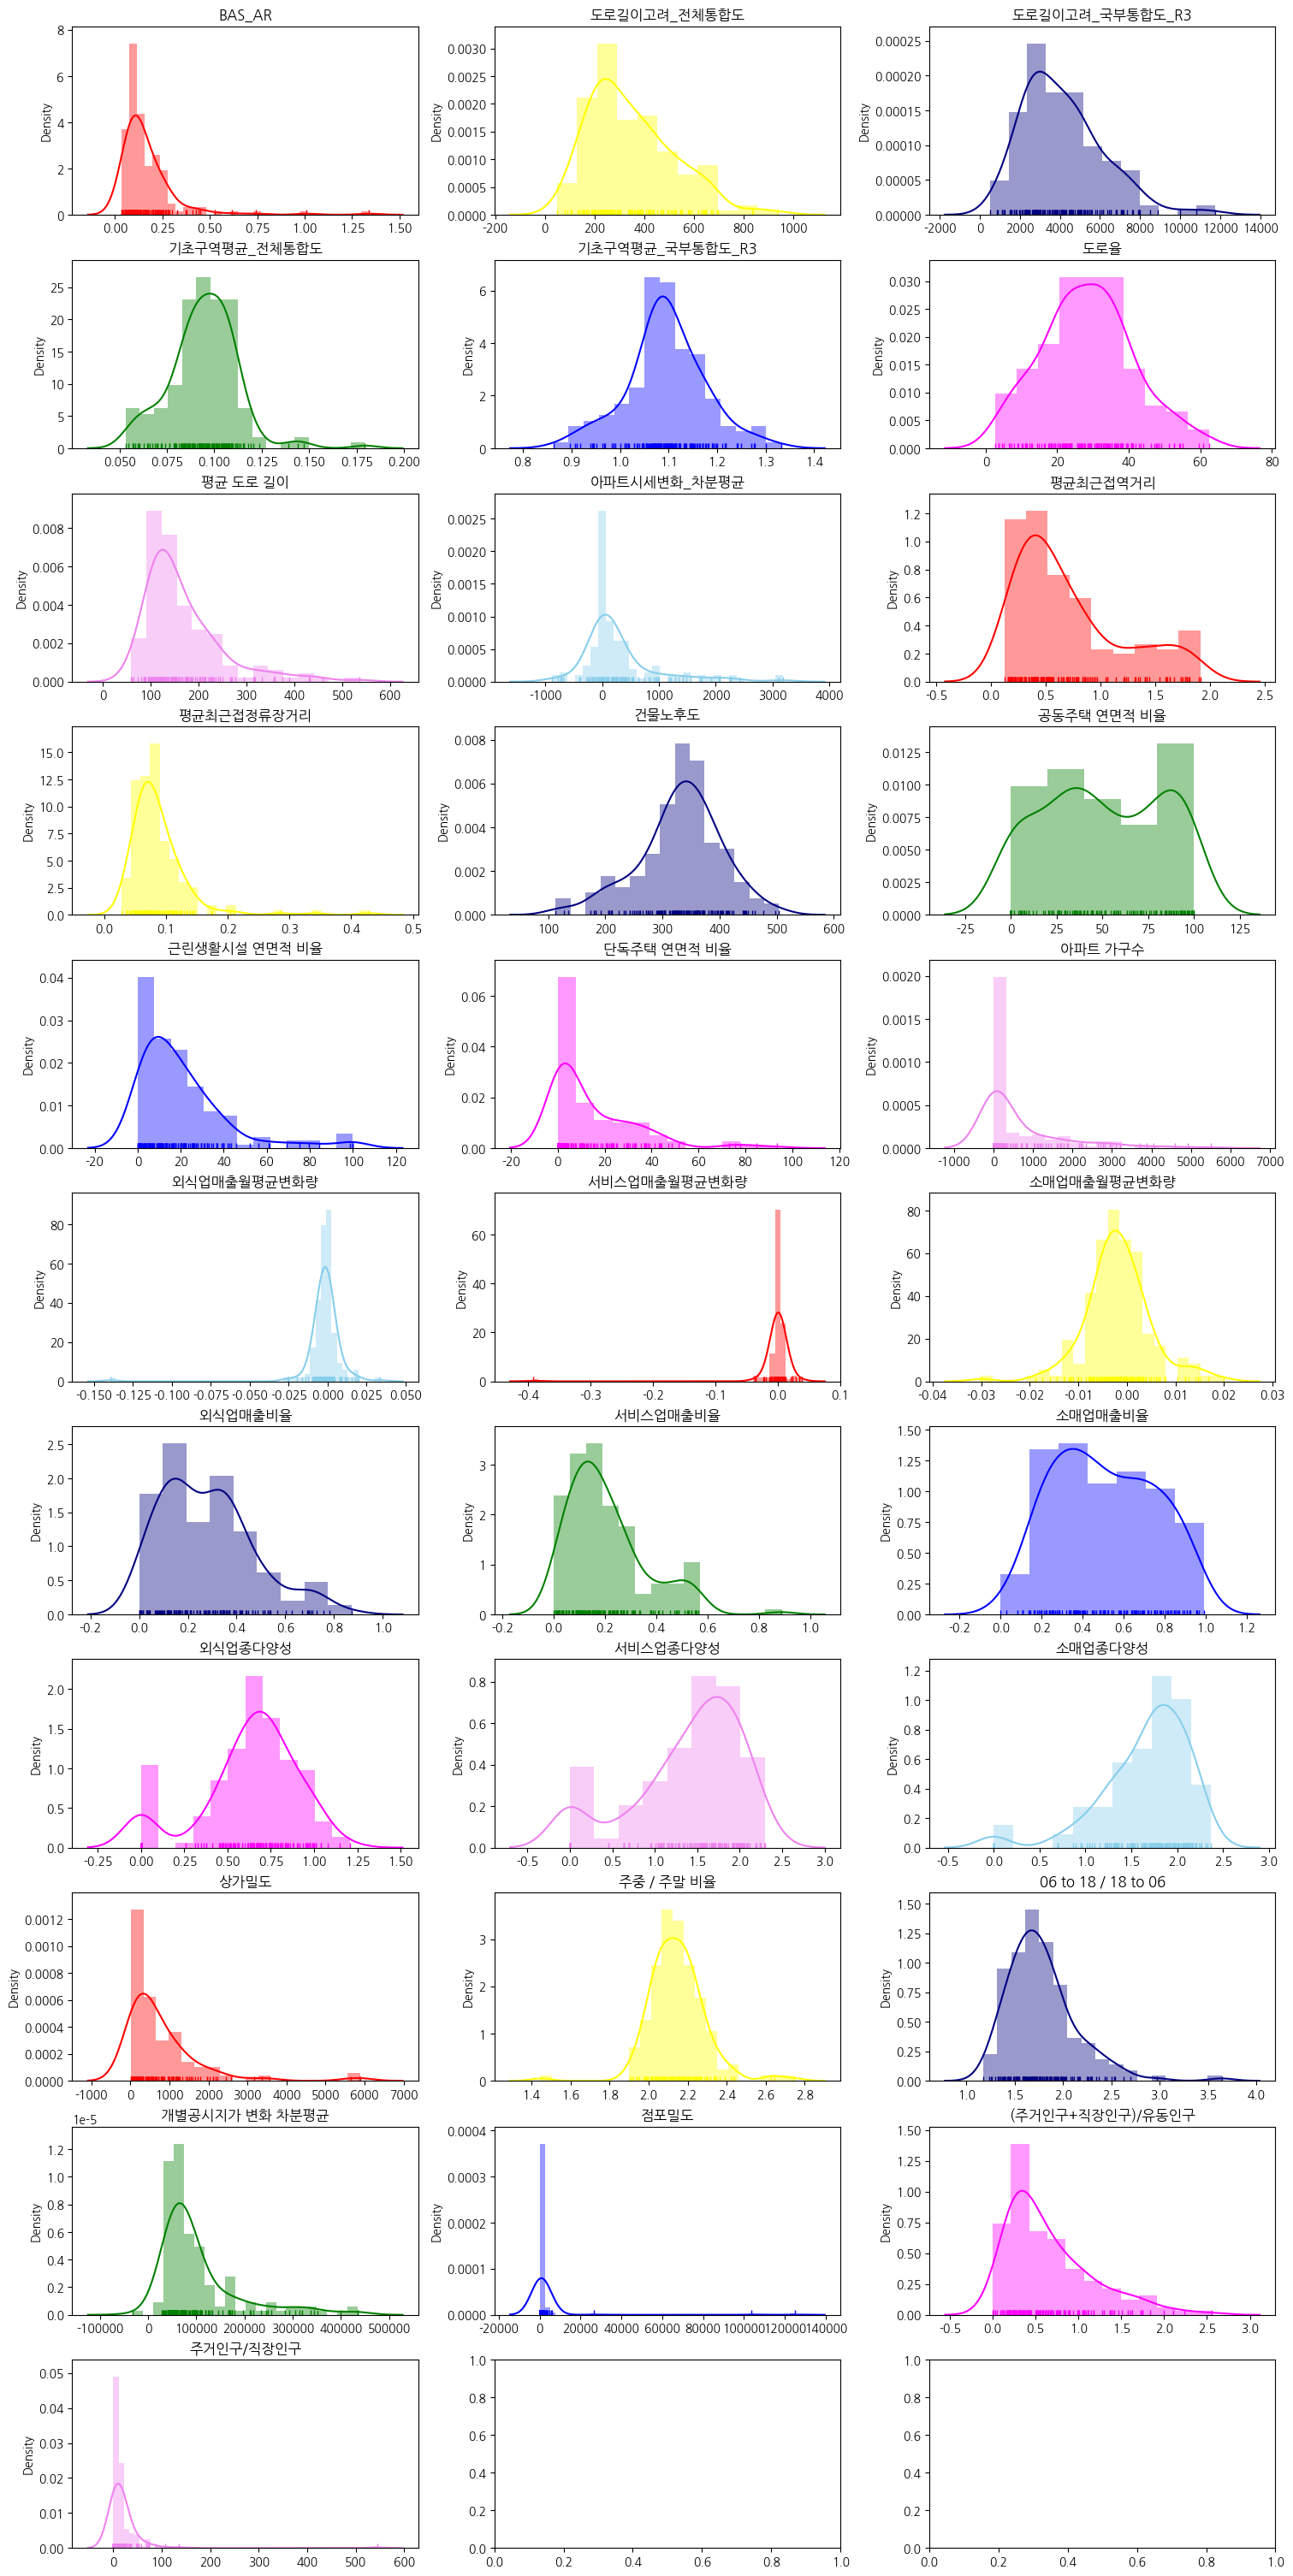

In [31]:
ind_var_col = list(range(1,9)) + list(range(11,34))
dX = clean_data.iloc[:,ind_var_col]

col_list = list(dX)
nrows = int(len(col_list)/3)+1
ncols = 3

fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(15,30),constrained_layout=True)
color = ['red','yellow','navy','green','blue','magenta','violet','skyblue']

for i in range(nrows):
    for j in range(ncols):
        if (ncols*i+j) == len(col_list):
            break
        
        sns.distplot(ax=axes[i,j], x=dX[col_list[(ncols*i+j)]], kde=True,color=color[(ncols*i+j) % len(color)],rug=True)
        axes[i,j].set_title(col_list[ncols*i+j])
         
plt.show()

# 2. 공간상관성 검증
- H0 : 군집이 존재하지 않는다. 즉, 모든 구역이 Randomness를 가진다.(AutoCorrelation이 없다.)
- 유의 수준 : 0.05
- 검정통계량 : Morans'I

In [220]:
ind_var_col = list(range(1,9)) + list(range(11,35))

gdf = clean_data.iloc[:,ind_var_col]
y = clean_data['평균영업기간'].values

In [16]:
w = Queen.from_dataframe(gdf)
w.transform = 'r'

In [17]:
# Assessing Global Spatial Autocorrelation
# calculate Morans'I. 
w = Queen.from_dataframe(gdf)
moran = Moran(y, w)
moran.I

0.19443415731667915

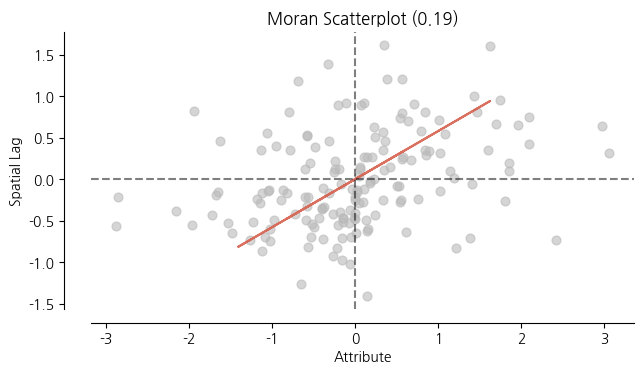

In [18]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

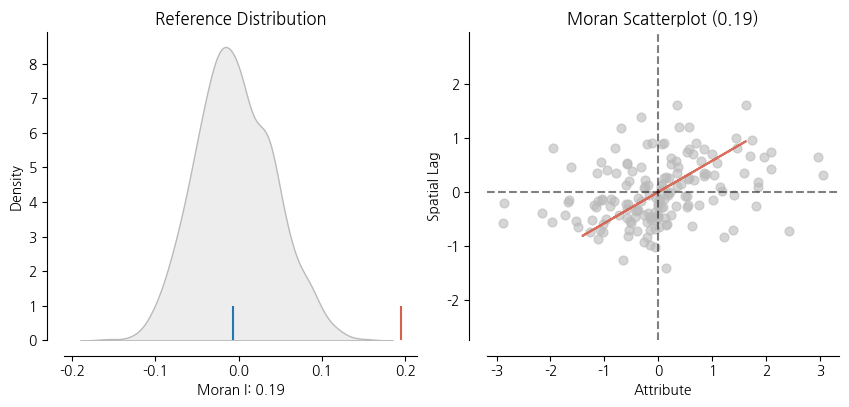

In [19]:
from splot.esda import plot_moran

plot_moran(moran, zstandard=True, figsize=(10,4))
plt.show()

In [20]:
moran.p_sim

0.001

- p-value가 0.001이므로 유의수준 5%이내에서 전역적으로 보았을 때 군집이 존재하다고 이야기 할수 있다.

# 3. LISA 검정
- 왜 국지적 모델(GWR)을 써야하는가?
- Morans'I를 통해서 공간적 의존성은 확인할 수 있으나 공간적 이질성은 확인할 수가 없다.
- 공간적 의존성 : 공간상의 한 지점에서 측정된 현상이 다른 지점에서의 측정값과 서로 관련이 있을 때 나타난다.
- 공간적 이질성 : 각 지점이나 지역에 내재된 고유성에서 발생하게 되는 자료의 지리적 변이나 통계적 특성의 차이를 말한다.
- LISA 검정을 통해서 공간적 이질성이 존재하는지 확인해본다.
- H0 : 특정지역별로 공간적 군집이 형성되지 않는다.
- 유의 수준 : 0.05

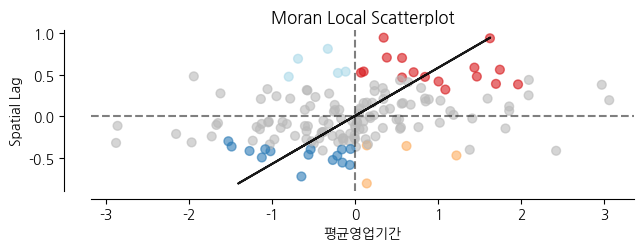

In [21]:
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local

# calculate Moran_Local and plot
lisa = Moran_Local(y, w)
fig, ax = moran_scatterplot(lisa, p=0.05)
ax.set_xlabel('평균영업기간')
ax.set_ylabel('Spatial Lag')
plt.show()

In [22]:
lisa.sim

array([[-0.58215175, -0.3348654 ,  0.44829417, ...,  0.30805051,
         0.07895351, -0.61925727],
       [ 0.40694501,  0.66834162, -0.53648371, ...,  0.1041344 ,
         0.04602692, -0.20933574],
       [-0.43596743, -0.8651677 ,  0.35647704, ..., -0.31849114,
        -0.02736245,  0.6402455 ],
       ...,
       [-0.55844545, -0.85705932,  0.56215417, ...,  0.09239783,
         0.0210821 , -0.18574236],
       [ 0.32013856,  0.53735037, -0.33743656, ..., -0.40123862,
        -0.10755571,  0.80658829],
       [-0.17420438, -0.27868311, -0.02752021, ..., -0.02721971,
         0.01368148,  0.0547183 ]])

In [23]:
lisa.sim.shape
# 158개 row를 999번 시행하여 값 생성

(999, 158)

In [24]:
sig = lisa.p_sim < 0.05
sig.sum()

40

In [25]:
hotspots = lisa.q==1 * sig
hotspots.sum()

16

In [26]:
# HH Area
clean_data[hotspots]

,BAS_ID,BAS_AR,INT_LOAD,INT_LOAD_R3,INT_BAS,INT_BAS_R3,도로율,평균 도로 길이,APART_DIFF_AVG,평균영업기간,...,상가밀도,주중 / 주말 비율,06 to 18 / 18 to 06,BUILD_DIFF_AVG,점포밀도,(주거인구+직장인구)/유동인구,주거인구/직장인구,x,y,geometry
3,21303,0.270679,475.038010,6080.093135,0.084712,1.079401,15.517121,105.011320,912.50000,153.728003,...,7.388826,2.273528,2.246297,97041.79104,461.266314,0.201775,12.617228,126.698730,37.518981,"POLYGON ((126.70215 37.51767, 126.70204 37.517..."
4,21304,0.073319,273.241567,3575.514233,0.092931,1.107098,32.713927,134.361765,369.23100,172.605265,...,1786.712858,2.016228,2.004099,166589.33650,1660.729601,0.354007,3.918781,126.703419,37.519319,"POLYGON ((126.70466 37.52105, 126.70466 37.521..."
5,21305,0.098059,523.710848,6145.133162,0.095792,1.100614,38.069916,106.077128,0.00000,179.564066,...,856.627133,2.048316,1.997069,69414.52880,4566.907644,0.376629,4.180348,126.703004,37.515329,"POLYGON ((126.70432 37.51753, 126.70426 37.517..."
6,21306,0.284578,649.381963,7939.781286,0.087015,1.078935,12.802792,117.955382,1753.75000,145.382862,...,66.765527,1.953813,2.429456,76053.06346,5882.780945,2.558570,49.280796,126.697205,37.515679,"POLYGON ((126.70215 37.51767, 126.70214 37.517..."
8,21308,0.229900,421.903482,5071.581658,0.093441,1.153545,9.134493,156.407455,0.00000,171.724749,...,73.945194,2.262532,1.770196,67064.35185,406.738655,1.835686,19.015844,126.694636,37.509724,"POLYGON ((126.69275 37.51095, 126.69369 37.510..."
9,21309,0.102131,342.128741,4248.872704,0.098518,1.144899,33.748921,149.365524,1716.71400,131.415793,...,773.516366,2.146131,1.985019,77593.49776,1010.378351,0.438911,8.377488,126.702572,37.510880,"POLYGON ((126.70394 37.51300, 126.70393 37.512..."
11,21311,0.118429,379.037641,4513.843601,0.092221,1.077737,40.978510,125.566133,174.78600,187.606864,...,1165.255132,2.266419,1.979216,99730.09950,1194.293257,1.068572,9.656965,126.706451,37.518751,"POLYGON ((126.71000 37.51726, 126.71000 37.517..."
12,21312,0.251633,475.978325,5835.218463,0.096477,1.135147,23.254771,227.820900,536.21200,149.594331,...,842.496811,2.202115,1.910853,72588.12950,524.010177,0.990801,9.162677,126.706919,37.515098,"POLYGON ((126.70998 37.51718, 126.70996 37.517..."
67,21367,0.228448,433.242790,5042.136816,0.094212,1.099477,23.912363,125.875000,168.32500,177.378043,...,26.264183,2.244106,1.861148,86329.74684,164.718929,1.998314,52.758156,126.696109,37.507611,"POLYGON ((126.69990 37.50892, 126.69990 37.508..."
68,21368,0.218311,302.074763,3370.850035,0.088329,1.013514,5.180353,79.951000,-172.09800,138.682993,...,59.548076,2.227330,1.885386,98608.75000,185.571481,0.583356,15.421209,126.692740,37.505831,"POLYGON ((126.69505 37.50601, 126.69556 37.505..."


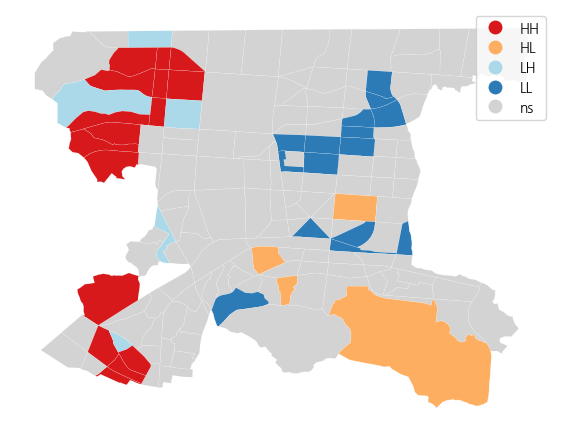

In [27]:
from splot.esda import lisa_cluster

gdf = gpd.GeoDataFrame(gdf)

lisa_cluster(lisa, gdf, p=0.05, figsize = (7,7))
plt.show()

- 총 13곳의 hotspot이 존재한다. 따라서 공간적 이질성을 가진다고 판단할 수 있고, GWR 모델을 고려해야 한다.

# 4. OLS

## 4.1 독립변수, 종속변수 설정

In [25]:
import statsmodels.api as sm

In [30]:
X = clean_data.iloc[:,ind_var_col].values
X = sm.add_constant(X)
y = clean_data.loc[:,'평균영업기간'].values

ols_model = sm.OLS(y,X)
results = ols_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     4.954
Date:                Mon, 08 Nov 2021   Prob (F-statistic):           6.21e-11
Time:                        11:27:07   Log-Likelihood:                -699.83
No. Observations:                 158   AIC:                             1464.
Df Residuals:                     126   BIC:                             1562.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        146.8016     53.695      2.734      0.007      40.540     253.063
x1             5.7305     13.010      0.440      0.660     -20.017      31.478
x2            -0.0044      0.060     -0.073      0.942      -0.123       0.114
x3             0.0023      0.005      0.471      0.638      -0.008       0.012
x4          -129.3333    252.890     -0.511      0.610    -629.795     371.128
x5           -30.4214     39.128     -0.777      0.438    -107.854      47.011
x6            -0.0087      0.237     -0.037      0.971      -0.479       0.461
x7            -0.0077      0.035     -0.223      0.824      -0.076       0.061
x8            -0.0045      0.003     -1.466      0.145      -0.010       0.002
x9             6.4805      5.212      1.244      0.216      -3.833      16.794
x10         -150.3213     55.872     -2.690      0.008    -260.891     -39.751
x11            0.1110      0.032      3.419      0.001       0.047       0.175
x12            0.3465      0.132      2.634      0.009       0.086       0.607
x13            0.1901      0.165      1.153      0.251      -0.136       0.516
x14            0.4398      0.167      2.636      0.009       0.110       0.770
x15           -0.0013      0.003     -0.494      0.622      -0.006       0.004
x16          268.4838    166.841      1.609      0.110     -61.690     598.657
x17           15.4430     74.838      0.206      0.837    -132.660     163.546
x18         -511.5083    317.792     -1.610      0.110   -1140.409     117.392
x19            7.7753     23.404      0.332      0.740     -38.540      54.091
x20           27.0630     23.896      1.133      0.260     -20.226      74.352
x21            1.3938     20.998      0.066      0.947     -40.162      42.949
x22          -22.5455      9.302     -2.424      0.017     -40.954      -4.137
x23           10.1209      4.925      2.055      0.042       0.375      19.867
x24          -25.2619      6.297     -4.012      0.000     -37.724     -12.800
x25            0.0035      0.003      1.085      0.280      -0.003       0.010
x26          -13.7277     19.040     -0.721      0.472     -51.408      23.953
x27           13.6757      9.224      1.483      0.141      -4.578      31.930
x28         -1.27e-05   3.52e-05     -0.361      0.719   -8.23e-05    5.69e-05
x29           -0.0003      0.000     -1.423      0.157      -0.001    9.91e-05
x30            6.5775      5.214      1.261      0.209      -3.741      16.896
x31           -0.0971      0.051     -1.901      0.060      -0.198       0.004
==============================================================================
Omnibus:                        1.685   Durbin-Watson:                   1.810
Prob(Omnibus):                  0.431   Jarque-Bera (JB):                1.266
Skew:                          -0.133   Prob(JB):                        0.531
Ku

## 4.2 Modeling

### 4.2.1 다중공선성

In [22]:
def check_vif(dX):
    vif = pd.DataFrame()
    vif['VIF Factor'] = [variance_inflation_factor(dX.values,i) for i in range(dX.values.shape[1])] 
    vif['features'] = dX.columns
    vif = vif.sort_values("VIF Factor").reset_index(drop=True)
    
    return vif

result = check_vif(clean_data.iloc[:,ind_var_col])
result.iloc[-10:,]

,VIF Factor,features
21,41.515975,건물노후도
22,57.110633,서비스업매출비율
23,100.628138,06 to 18 / 18 to 06
24,104.529884,외식업매출비율
25,159.864383,도로길이고려_국부통합도_R3
26,163.501634,도로길이고려_전체통합도
27,189.819260,기초구역평균_전체통합도
28,255.671373,소매업매출비율
29,457.904634,주중 / 주말 비율
30,534.276584,기초구역평균_국부통합도_R3


#### 4.2.1.2 column 제거

In [23]:
def RFE(df):
    flag = True
    next_col = list(dX.columns)
    
    while flag:
        local = df.loc[:,next_col]
        result = check_vif(local)

        if len(result[result['VIF Factor'] > 10]) == 0:
            return result # 유일한 탈출 조건
        
        next_col = result.iloc[:-1,1].values.tolist()
        
vif_result = RFE(dX)
optimal_feature = vif_result['features'].values.tolist()
optimal_feature

['서비스업매출월평균변화량',
 '외식업매출월평균변화량',
 '아파트시세변화_차분평균',
 '소매업매출월평균변화량',
 '주거인구/직장인구',
 '점포밀도',
 '아파트 가구수',
 '단독주택 연면적 비율',
 '서비스업매출비율',
 '상가밀도',
 '외식업매출비율',
 '개별공시지가 변화 차분평균',
 '평균최근접역거리',
 '근린생활시설 연면적 비율',
 '(주거인구+직장인구)/유동인구',
 'BAS_AR',
 '도로길이고려_국부통합도_R3',
 '평균 도로 길이',
 '외식업종다양성',
 '평균최근접정류장거리',
 '공동주택 연면적 비율']

#### 4.2.1.3 Remodeling


In [26]:
X = clean_data.loc[:,optimal_feature].values
X = sm.add_constant(X)
y = clean_data.loc[:,'평균영업기간'].values

ols_model = sm.OLS(y,X)
results = ols_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     3.922
Date:                Tue, 09 Nov 2021   Prob (F-statistic):           6.80e-07
Time:                        09:08:13   Log-Likelihood:                -688.36
No. Observations:                 152   AIC:                             1421.
Df Residuals:                     130   BIC:                             1487.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         95.2808     17.146      5.557      0.000      61.360     129.201
x1           -46.5085     69.567     -0.669      0.505    -184.138      91.121
x2           107.8103    171.595      0.628      0.531    -231.670     447.290
x3            -0.0071      0.003     -2.226      0.028      -0.013      -0.001
x4          -482.9279    337.979     -1.429      0.155   -1151.579     185.723
x5            -0.0749      0.051     -1.479      0.142      -0.175       0.025
x6            -0.0003      0.000     -1.768      0.079      -0.001    4.15e-05
x7            -0.0055      0.003     -2.134      0.035      -0.011      -0.000
x8             0.4051      0.178      2.276      0.024       0.053       0.757
x9            27.2688     14.189      1.922      0.057      -0.803      55.340
x10            0.0007      0.003      0.235      0.815      -0.005       0.007
x11           21.1253     11.879      1.778      0.078      -2.376      44.626
x12         -2.62e-05   3.48e-05     -0.753      0.453    -9.5e-05    4.26e-05
x13           11.9750      5.010      2.390      0.018       2.062      21.887
x14            0.2945      0.179      1.643      0.103      -0.060       0.649
x15            5.1466      5.430      0.948      0.345      -5.595      15.889
x16           -6.9397     20.552     -0.338      0.736     -47.598      33.719
x17            0.0021      0.001      1.807      0.073      -0.000       0.004
x18           -0.0205      0.031     -0.658      0.511      -0.082       0.041
x19          -21.0961      9.054     -2.330      0.021     -39.009      -3.183
x20          -82.1059     59.355     -1.383      0.169    -199.532      35.320
x21            0.4377      0.138      3.183      0.002       0.166       0.710
==============================================================================
Omnibus:                        0.733   Durbin-Watson:                   1.628
Prob(Omnibus):                  0.693   Jarque-Bera (JB):                0.845
Skew:                          -0.092   Prob(JB):                        0.655
Kurtosis:                       2.684   Cond. No.                     2.33e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.33e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 4.2.2 잔차분석
- 회귀모형에 대한 가정(정규성, 등분산성, 독립성)을 충족하는지에 대한 검정, 이상치가 개입하는지에 대한 검정을 하는 절차

In [239]:
import scipy as sp
from scipy import stats

#### 4.2.2.1 잔차 정규성

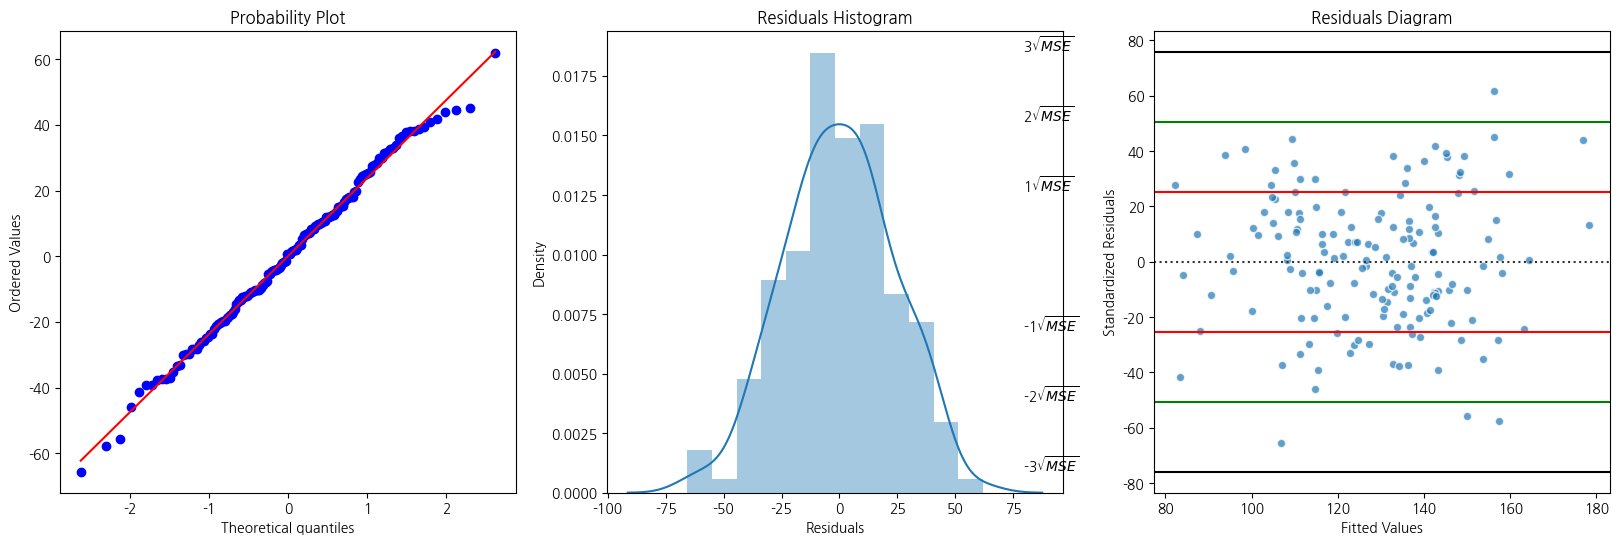

In [172]:
figure, axs = plt.subplots(1,3, figsize = (20,6))

# 잔차 Q-Q  plot
# sm.ProbPlot(fit1.resid).qqplot(line="s",ax=axs[0])
sp.stats.probplot(results.resid, dist='norm', fit=True, plot=axs[0])

# 잔차의 히스토그램
sns.distplot(x = results.resid , ax = axs[1])
axs[1].set_xlabel("Residuals")
axs[1].set_title("Residuals Histogram")

# 잔차도 MSE 라인
yhat = pd.DataFrame(results.fittedvalues)
temp = pd.concat([yhat,clean_data.loc[:,'평균영업기간']],axis=1)
temp.columns = ['yhat','MEDV']

sns.residplot(x='yhat',y='MEDV',data=temp, scatter_kws = {'edgecolor':"white", "alpha":0.7}, line_kws = {"color":"red"})
MSE_sq = np.sqrt(results.mse_resid) #RMSE

# 잔차도 MSE line
for i, c in enumerate(["red", "green", "black"]):
    axs[2].axhline( (i+1) * MSE_sq, color = c)
    axs[2].axhline( -(i+1) * MSE_sq, color = c)
    
    axs[2].text(47, (i+1) * MSE_sq, f"{i+1}"r'${}\sqrt{MSE}$')
    axs[2].text(47, -(i+1) * MSE_sq, f"-{i+1}"r'${}\sqrt{MSE}$')

axs[2].set_xlabel("Fitted Values")
axs[2].set_ylabel("Standardized Residuals")
axs[2].set_title("Residuals Diagram")

plt.show()

In [173]:
test = stats.shapiro(results.resid)
print('검정통계량 : {0}\np-value : {1}'.format(test[0],test[1]))

# 귀무가설을 기각할 수 없으므로 잔차는 정규성을 따른다.

검정통계량 : 0.9951688647270203
p-value : 0.8864861130714417


#### 4.2.2.2 잔차 등분산성
- 종속 변수의 값의 분산이 독립 변수의 값과 상관없이 고정된 값을 가져야 한다.
- 실제 데이터는 독립 변수 값의 크기가 커지면 종속 변수 값의 분산도 커지는 이분산성 문제가 발생한다.

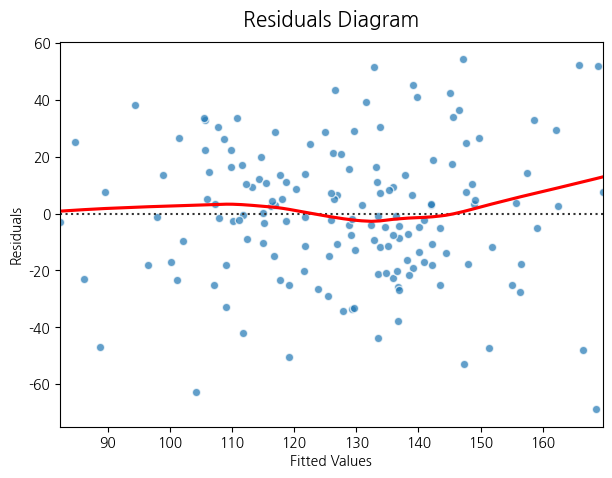

In [36]:
fig = plt.figure(figsize= (7,5))

p = sns.residplot(x = "yhat", y = "MEDV", 
                  data = temp, 
                  scatter_kws = {'edgecolor':"white", "alpha":0.7},
                  lowess = True,
              line_kws = {"color":"red"})

p.set_title("Residuals Diagram", fontsize=15, y=1.02)
p.set(xlabel= "Fitted Values", ylabel = "Residuals")

plt.show()

In [37]:
from sklearn.linear_model import LinearRegression
from scipy.stats import chisqprob


def breusch_pagan_test(x, y):
    '''
    Breusch-Pagan test for heteroskedasticity in a linear regression model:
    H_0 = No heteroskedasticity.
    H_1 = Heteroskedasticity is present.

    Inputs:
    x = a numpy.ndarray containing the predictor variables. Shape = (nSamples, nPredictors).
    y = a 1D numpy.ndarray containing the response variable. Shape = (nSamples, ).

    Outputs a list containing three elements:
    1. the Breusch-Pagan test statistic.
    2. the p-value for the test.
    3. the test result.
    '''

    if y.ndim != 1:
        raise SystemExit('Error: y has more than 1 dimension.')
    if x.shape[0] != y.shape[0]:
        raise SystemExit('Error: the number of samples differs between x and y.')
    else:
        n_samples = y.shape[0]

    # fit an OLS linear model to y using x:
    lm = LinearRegression()
    lm.fit(x, y)

    # calculate the squared errors:
    err = (y - lm.predict(x))**2

    # fit an auxiliary regression to the squared errors:
    # why?: to estimate the variance in err explained by x
    lm.fit(x, err)
    pred_err = lm.predict(x)
    del lm

    # calculate the coefficient of determination:
    ss_tot = sum((err - np.mean(err))**2)
    ss_res = sum((err - pred_err)**2)
    r2 = 1 - (ss_res / ss_tot)
    del err, pred_err, ss_res, ss_tot

    # calculate the Lagrange multiplier:
    LM = n_samples * r2
    del r2

    # calculate p-value. degrees of freedom = number of predictors.
    # this is equivalent to (p - 1) parameter restrictions in Wikipedia entry.
    pval = chisqprob(LM, x.shape[1])

    if pval < 0.01:
        test_result = 'Heteroskedasticity present at 99% CI.'
    elif pval < 0.05:
        test_result = 'Heteroskedasticity present at 95% CI.'
    else:
        test_result = 'No significant heteroskedasticity.'
    return [LM, pval, test_result]

tX = clean_data.iloc[:,ind_var_col]
ty = X = clean_data.loc[:,'평균영업기간']

result = breusch_pagan_test(tX,ty)
print('LM : {}\np-value : {}\ntest_result {}'.format(result[0],result[1],result[2]))

# p-value가 유의수준 0.05보다 크므로 귀무가설을 기각할 수 없다. 따라서 등분산성을 만족한다고 할수 있다.

LM : 34.56018530869065
p-value : 0.30155742144138353
test_result No significant heteroskedasticity.


#### 4.2.2.3 잔차 독립성

In [38]:
from statsmodels.stats.stattools import durbin_watson

print(f"D-W 통계량: {round(durbin_watson(results.resid),3)}")

# 통계량이 1.5~2.5 사이이므로 잔차들이 자기상관성을 가지고 있지 않다. 따라서 독립성을 만족한다.

D-W 통계량: 1.88


### 4.2.3 PCA

In [39]:
# Scaling
dX_scaled = StandardScaler().fit_transform(dX.values)
std_df = pd.DataFrame(dX_scaled, index=dX.index, columns=dX.columns)

# PCA
pca = PCA(n_components=len(dX.columns))
pca_array = pca.fit_transform(std_df)
pca_df = pd.DataFrame(pca_array, index=dX.index,
                      columns=[f"pca{num+1}" for num in range(dX.shape[1])])
pca_df.head()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,...,pca22,pca23,pca24,pca25,pca26,pca27,pca28,pca29,pca30,pca31
0,3.739008,2.904297,-0.380422,-2.605023,-0.174026,-1.773219,1.107109,0.918385,-0.360035,-0.846281,...,-0.108455,0.874329,-0.209730,-0.424795,-0.637357,0.215993,0.105918,-0.071777,-0.030181,1.227270e-10
1,3.715446,0.698343,-0.090331,0.119496,-1.505810,-1.476502,-2.390645,2.034768,-0.098198,-1.815423,...,1.116705,-0.059598,0.957183,-0.020341,0.085428,-0.403747,-1.040088,-0.105892,-0.025676,-2.425321e-09
2,0.506528,0.679193,0.022374,-0.258493,0.469416,-1.991284,-0.876568,0.334825,-1.404148,-0.112977,...,0.381584,0.703107,-0.805025,0.040763,1.091423,-0.362486,0.244693,-0.106121,-0.046930,-1.049890e-09
3,2.911541,2.261929,-2.423118,-2.468401,0.166739,1.455578,0.264688,0.135047,1.173363,-1.415888,...,0.087095,0.000572,0.652936,1.310886,0.452270,0.473579,-0.063338,-0.080213,0.047606,1.704673e-09
4,-1.437264,1.162961,-1.110510,-0.547171,0.187204,1.053510,-0.982206,-1.029943,-1.086769,-0.759714,...,-0.370531,0.146818,0.182760,-0.037966,0.378125,0.140995,-0.190959,0.077568,0.051743,-4.542685e-09


In [40]:
# 고윳값과 누적기여율 계산

result = pd.DataFrame({'고윳값':pca.explained_variance_,
             '기여율':pca.explained_variance_ratio_},
            index=np.array([f"pca{num+1}" for num in range(dX.shape[1])]))
result['누적기여율'] = result['기여율'].cumsum()
result

,고윳값,기여율,누적기여율
pca1,4.988144e+00,1.598895e-01,0.159889
pca2,3.738308e+00,1.198273e-01,0.279717
pca3,3.132014e+00,1.003933e-01,0.380110
pca4,2.728521e+00,8.745974e-02,0.467570
pca5,2.166984e+00,6.946029e-02,0.537030
pca6,1.660212e+00,5.321626e-02,0.590246
pca7,1.550546e+00,4.970105e-02,0.639947
pca8,1.321311e+00,4.235317e-02,0.682301
pca9,1.211481e+00,3.883269e-02,0.721133
pca10,1.029992e+00,3.301526e-02,0.754149


In [41]:
# 개별 고윳값 즉, 각 주성분 마다 고윳값이 0.7이상인 주성분들, 누적기여율이 80% 이상이 넘어거지는 지점까지의 
# 주성분들을 기준으로 하여 적절한 주성분 개수를 설정한다. 

condition = (result['고윳값'] >= 0.7) & (result['누적기여율'] >= 0.8)
pca_index = list(result[condition].reset_index().index)

In [42]:
pca_columns = list(dX.iloc[:,pca_index].columns)
pca_columns

['BAS_AR', 'INT_LOAD']

In [43]:
X = dX.loc[:,pca_columns].values

In [44]:
#Calibrate GWR model
# 평균영업기간

ols_model = sm.OLS(y,X)
results = ols_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.785
Model:                            OLS   Adj. R-squared (uncentered):              0.782
Method:                 Least Squares   F-statistic:                              284.6
Date:                Thu, 04 Nov 2021   Prob (F-statistic):                    8.94e-53
Time:                        13:51:55   Log-Likelihood:                         -874.11
No. Observations:                 158   AIC:                                      1752.
Df Residuals:                     156   BIC:                                      1758.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            35.2019     19.276      1.826      0.070      -2.873      73.277
x2             0.2844      0.016     17.796      0.000       0.253       0.316
==============================================================================
Omnibus:                        2.283   Durbin-Watson:                   1.205
Prob(Omnibus):                  0.319   Jarque-Bera (JB):                1.947
Skew:                          -0.265   Prob(JB):                        0.378
Kurtosis:                       3.118   Cond. No.                     1.52e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 4.2.3.1 Remodeling
- 이번에는 다중공선성을 제거했을 때 OLS에서 통계적으로 관련이 없는 column들을 제거해보고 돌려보자.

In [45]:
use_col = [0,8,9,10,12,15,16,17]

remove_low_pvalue = dX.iloc[:,use_col]
X = remove_low_pvalue.values

In [46]:
#Calibrate GWR model
# 평균영업기간

ols_model = sm.OLS(y,X)
results = ols_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.949
Model:                            OLS   Adj. R-squared (uncentered):              0.946
Method:                 Least Squares   F-statistic:                              346.3
Date:                Thu, 04 Nov 2021   Prob (F-statistic):                    1.30e-92
Time:                        13:51:55   Log-Likelihood:                         -760.95
No. Observations:                 158   AIC:                                      1538.
Df Residuals:                     150   BIC:                                      1562.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -4.6315     12.119     -0.382      0.703     -28.578      19.314
x2            22.6722      5.360      4.230      0.000      12.081      33.264
x3           -10.7086     56.080     -0.191      0.849    -121.518     100.101
x4             0.3184      0.016     20.063      0.000       0.287       0.350
x5             0.2716      0.108      2.509      0.013       0.058       0.485
x6          6.032e-10      1e-08      0.060      0.952   -1.92e-08    2.04e-08
x7         -4.193e-10   7.73e-09     -0.054      0.957   -1.57e-08    1.49e-08
x8         -4.112e-08   7.13e-08     -0.577      0.565   -1.82e-07    9.97e-08
==============================================================================
Omnibus:                       10.214   Durbin-Watson:                   1.670
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               13.833
Skew:                           0.391   Prob(JB):                     0.000991
Kurtosis:                       4.220   Cond. No.                     6.42e+10
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 6.42e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 4.2.4 교차 검증

In [47]:
# 필요한 모듈 import
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [48]:
train_scores = np.zeros(5)
test_scores = np.zeros(5)
train_rmse = np.zeros(5)
test_rmse = np.zeros(5)


cv = KFold(5, shuffle=True, random_state=0)

for i, (idx_train, idx_test) in enumerate(cv.split(X = X, y = y)):
    local_X_train, local_y_train = X[idx_train], y[idx_train]
    local_X_test, local_y_test = X[idx_test], y[idx_test]
    
    model = sm.OLS(local_y_train,local_X_train)
    result = model.fit()
    
    pred = result.predict(local_X_test)
    
    train_scores[i] = result.rsquared
    test_scores[i] = r2_score(local_y_test,pred)
    train_rmse[i] = np.sqrt(result.mse_model)
    test_rmse[i] = np.sqrt(mean_squared_error(local_y_test,pred))
    
    print('====================== FOLD {} ======================'.format(i))
    print('학습 RMSE : {:.8f}, 검증 RMSE : {:.8f}'.format(np.sqrt(result.mse_model),test_rmse[i]))
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, test_scores[i]))
    
print('\n===================== 평균 결과 ======================')
print('학습 평균 R2 : {:.8f}   검증 평균 R2 : {:.8f}'.format(train_scores.mean(),test_scores.mean()))
print('학습 평균 RMSE : {:.8f}   검증 평균 RMSE : {:.8f}'.format(train_rmse.mean(), test_rmse.mean()))

====================== FOLD 0 ======================
학습 RMSE : 517.13756401, 검증 RMSE : 26.95363789
학습 R2 = 0.94751650, 검증 R2 = -0.00709706
====================== FOLD 1 ======================
학습 RMSE : 518.72446747, 검증 RMSE : 34.53335881
학습 R2 = 0.95273470, 검증 R2 = -0.21480094
====================== FOLD 2 ======================
학습 RMSE : 504.22473571, 검증 RMSE : 29.70161813
학습 R2 = 0.94686923, 검증 R2 = -0.17194361
====================== FOLD 3 ======================
학습 RMSE : 507.83752153, 검증 RMSE : 47.89060260
학습 R2 = 0.94602217, 검증 R2 = -1.78538805
====================== FOLD 4 ======================
학습 RMSE : 504.85693807, 검증 RMSE : 36.70911348
학습 R2 = 0.95297429, 검증 R2 = -0.28641338

===================== 평균 결과 ======================
학습 평균 R2 : 0.94922338   검증 평균 R2 : -0.49312861
학습 평균 RMSE : 510.55624536   검증 평균 RMSE : 35.15766618


In [49]:
# 다중공선성이 있는 column들을 제거한 독립변수들을 사용함.

lr = LinearRegression()

kfold = KFold(n_splits=5, shuffle=True, random_state=140)
score = cross_val_score(lr, X, y, cv=kfold,scoring='r2')
print('교차 검증 점수 : ', score)
print('교차 검증 평균 점수 : ', score.mean())

교차 검증 점수 :  [ 0.2047782   0.06440551 -1.71803667 -0.84852394  0.17339567]
교차 검증 평균 점수 :  -0.4247962471410469


# 5. XGBoost

## 5.2 교차검증

In [50]:
# test & train set 분리
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size = 0.2,random_state = 1010)

In [51]:
# XGBoost 모델에 쓰일 parameter 정의
n_splits= 5
NUM_BOOST_ROUND = 10000
SEED = 1993 
xgb_params={ 'booster':'gblinear',
         'verbosity':0,
         'silent':1,
         'num_boost_rounds':160,
         'min_child_weight':1,
         'max_depth':4,
         'early_stopping_rounds':50,
         'eta':0.1,
         'sub_sample':1,
         'eval_metric':'rmse',
}

In [53]:
xgb_oof_train = np.zeros((X_train.shape[0],))
xgb_oof_test = np.zeros((X_test.shape[0],))

cv_list=[]

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=1010, shuffle=True)

# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm( enumerate( kfolds.split( X = X_train, y = y_train ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train_f , y_train_f = X_train[trn_ind], y_train[trn_ind]
    X_valid , y_valid = X_train[val_ind], y_train[val_ind]
    
    # XGBoost
    print("---TRAINING XGBOOST--")
    dtrain = xgb.DMatrix(X_train_f,y_train_f)
    dvalid = xgb.DMatrix(X_valid, y_valid)
    
    # model 정의 & 학습
    xgb_model = xgb.train(xgb_params,dtrain, NUM_BOOST_ROUND,
                     evals=[(dtrain,'train'),(dvalid,'valid')],
                        early_stopping_rounds=100,
                         verbose_eval=30)
    
    xgb_valid_pred = xgb_model.predict(dvalid)
    xgb_test_pred = xgb_model.predict(xgb.DMatrix(X_test,y_test))    
    
    cv_list.append(np.sqrt(mean_squared_error(y_valid,xgb_valid_pred)))
    
    xgb_oof_train[val_ind] = xgb_valid_pred
    xgb_oof_test += xgb_test_pred/n_splits
    print('='*80)

print(f"<LOCAL_TRAIN> OVERALL RMSE : {np.sqrt( mean_squared_error( y_train, xgb_oof_train ) )}")
print(f"<LOCAL_TEST>  OVERALL RMSE : {np.sqrt( mean_squared_error( y_test, xgb_oof_test ) )}")
print(f"<LOCAL_TRAIN> OVERALL R2 : {r2_score( y_train, xgb_oof_train ) }")
print(f"<LOCAL_TEST>  OVERALL R2 : {r2_score( y_test, xgb_oof_test ) }")

0it [00:00, ?it/s]

---TRAINING XGBOOST--
[0]	train-rmse:82.37667	valid-rmse:87.57670
[30]	train-rmse:25.95625	valid-rmse:38.93960
[60]	train-rmse:23.30541	valid-rmse:35.61102
[90]	train-rmse:22.33730	valid-rmse:34.39667
[120]	train-rmse:21.95888	valid-rmse:33.87865
[150]	train-rmse:21.80055	valid-rmse:33.59412
[180]	train-rmse:21.72802	valid-rmse:33.41204
[210]	train-rmse:21.69043	valid-rmse:33.28023
[240]	train-rmse:21.66785	valid-rmse:33.18160
[270]	train-rmse:21.65226	valid-rmse:33.10763
[300]	train-rmse:21.64008	valid-rmse:33.04615
[330]	train-rmse:21.62984	valid-rmse:32.99958
[360]	train-rmse:21.62080	valid-rmse:32.96013
[390]	train-rmse:21.61255	valid-rmse:32.92875
[420]	train-rmse:21.60496	valid-rmse:32.90133
[450]	train-rmse:21.59791	valid-rmse:32.87743
[480]	train-rmse:21.59133	valid-rmse:32.85628
[510]	train-rmse:21.58516	valid-rmse:32.83733
[540]	train-rmse:21.57934	valid-rmse:32.81976
[570]	train-rmse:21.57381	valid-rmse:32.80276
[600]	train-rmse:21.56860	valid-rmse:32.78758
[630]	train-rmse:

# 5. 지리가중회귀분석(GWR)

## 5.1 독립변수, 종속변수 설정
- 다중공선성을 제거한 독립변수들을 이용한다.

In [85]:
ind_var_col = list(range(1,9)) + list(range(11,34))

s_y1 = clean_data['평균영업기간'].values.reshape((-1,1)) # 종속변수1
s_y2 = clean_data['평균폐업기간'].values.reshape((-1,1)) # 종속변수2

# 다중공선성 제거
# s_X= clean_data.loc[:,optimal_feature].values

# Raw Data
# s_X = clean_data.iloc[:,ind_var_col].values

# 왜도 2이상인 데이터 log변환 후, standard scaling 함
# s_X= ss_scaled_dX.values


# 왜도 2이상인 데이터 log변환 후, standard scaling, 다중공선성 제거
# s_X= ss_scaled_dX.loc[:,optimal_feature].values

s_X = scaled_X.values
    
u = clean_data['x'] # 경도
v = clean_data['y'] # 위도
s_coords = list(zip(u,v))

s_X.shape

(152, 31)

In [258]:
ss_scaled_dX.shape

(158, 31)

### 5.2.1 종속변수 분포 확인


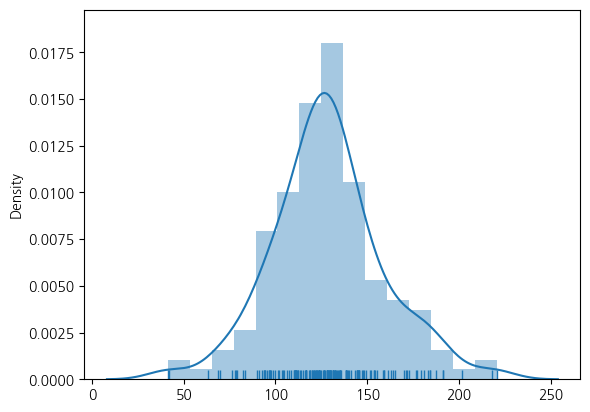

In [66]:
sns.distplot(s_y1,hist=True,kde=True,rug=True)
plt.show()

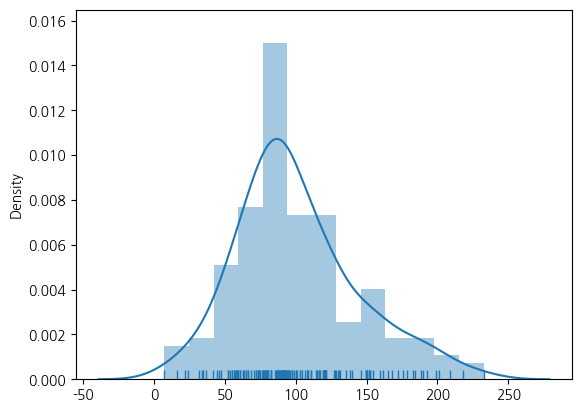

In [67]:
sns.distplot(s_y2,hist=True,kde=True,rug=True)
plt.show()

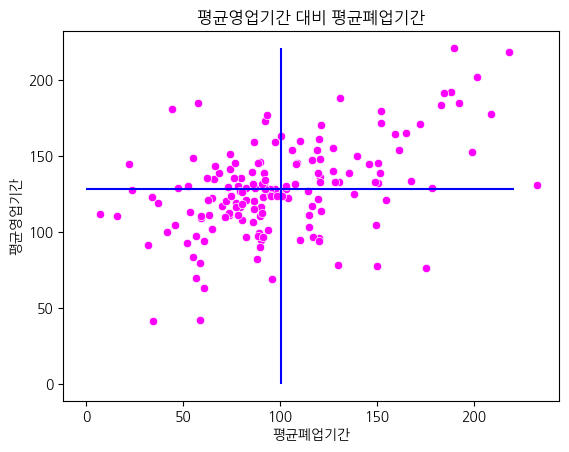

In [68]:
sns.scatterplot(data=clean_data,x='평균폐업기간',y='평균영업기간',color='magenta',palette='deep')
plt.title('평균영업기간 대비 평균폐업기간')
plt.hlines(clean_data['평균영업기간'].mean(),0,clean_data['평균영업기간'].max(),color='blue')
plt.vlines(clean_data['평균폐업기간'].mean(),0,clean_data['평균영업기간'].max(),color='blue')
plt.show()

### 5.2.2 상권변화 유형

In [59]:
kind_area = clean_data.copy()

In [60]:
avg_open_period = kind_area['평균영업기간']
avg_close_period = kind_area['평균폐업기간']

# 각 기간의 평균 저장
open_mean = avg_open_period.median()
close_mean = avg_close_period.median()

# kind column 생성
kind_area['KIND'] = ''

# HH : 정체형, 창업 진출입시 세심한 주의 상권
HH = clean_data[(open_mean < avg_open_period) & (close_mean < avg_close_period)]
kind_area.loc[(open_mean < avg_open_period) & (close_mean < avg_close_period),'KIND'] = 'HH'

# HL : 상권축소형, 경쟁력 있는 기존 업체 우위 상권
HL = clean_data[(open_mean < avg_open_period) & (close_mean > avg_close_period)]
kind_area.loc[(open_mean < avg_open_period) & (close_mean > avg_close_period),'KIND'] = 'HL'

# LH : 상권확장형, 경쟁력 있는 신규 창업 우위 상권
LH = clean_data[(open_mean > avg_open_period) & (close_mean < avg_close_period)]
kind_area.loc[(open_mean > avg_open_period) & (close_mean < avg_close_period),'KIND'] = 'LH'

# LL : 다이나믹(순환)형, 도시재생 및 신규 개발상권으로 창업 진출입시 세심한 주의 상권
LL = clean_data[(open_mean > avg_open_period) & (close_mean > avg_close_period)]
kind_area.loc[(open_mean > avg_open_period) & (close_mean > avg_close_period),'KIND'] = 'LL'

kind_list = [HH,HL,LH,LL]
title_list = ['HH','HL','LH','LL']

### 5.2.3 상관관계

#### 5.2.2.1 독립변수와 종속변수간의 상관계수

In [153]:
corr_df = clean_data.iloc[:,ind_var_col+[9]].corr()
corr = corr_df.loc[optimal_feature,'평균영업기간'].sort_values()
corr[abs(corr) > 0.07]

외식업종다양성            -0.345378
평균 도로 길이           -0.213118
점포밀도               -0.164169
BUILD_DIFF_AVG     -0.155611
상가밀도               -0.134432
APART_DIFF_AVG     -0.099813
아파트 가구수            -0.075011
평균최근접정류장거리         -0.071951
공동주택 연면적 비율         0.073420
INT_LOAD            0.093418
(주거인구+직장인구)/유동인구    0.136268
평균최근접역거리            0.277278
단독주택 연면적 비율         0.286487
Name: 평균영업기간, dtype: float64

#### 5.2.2.2 상관 그래프

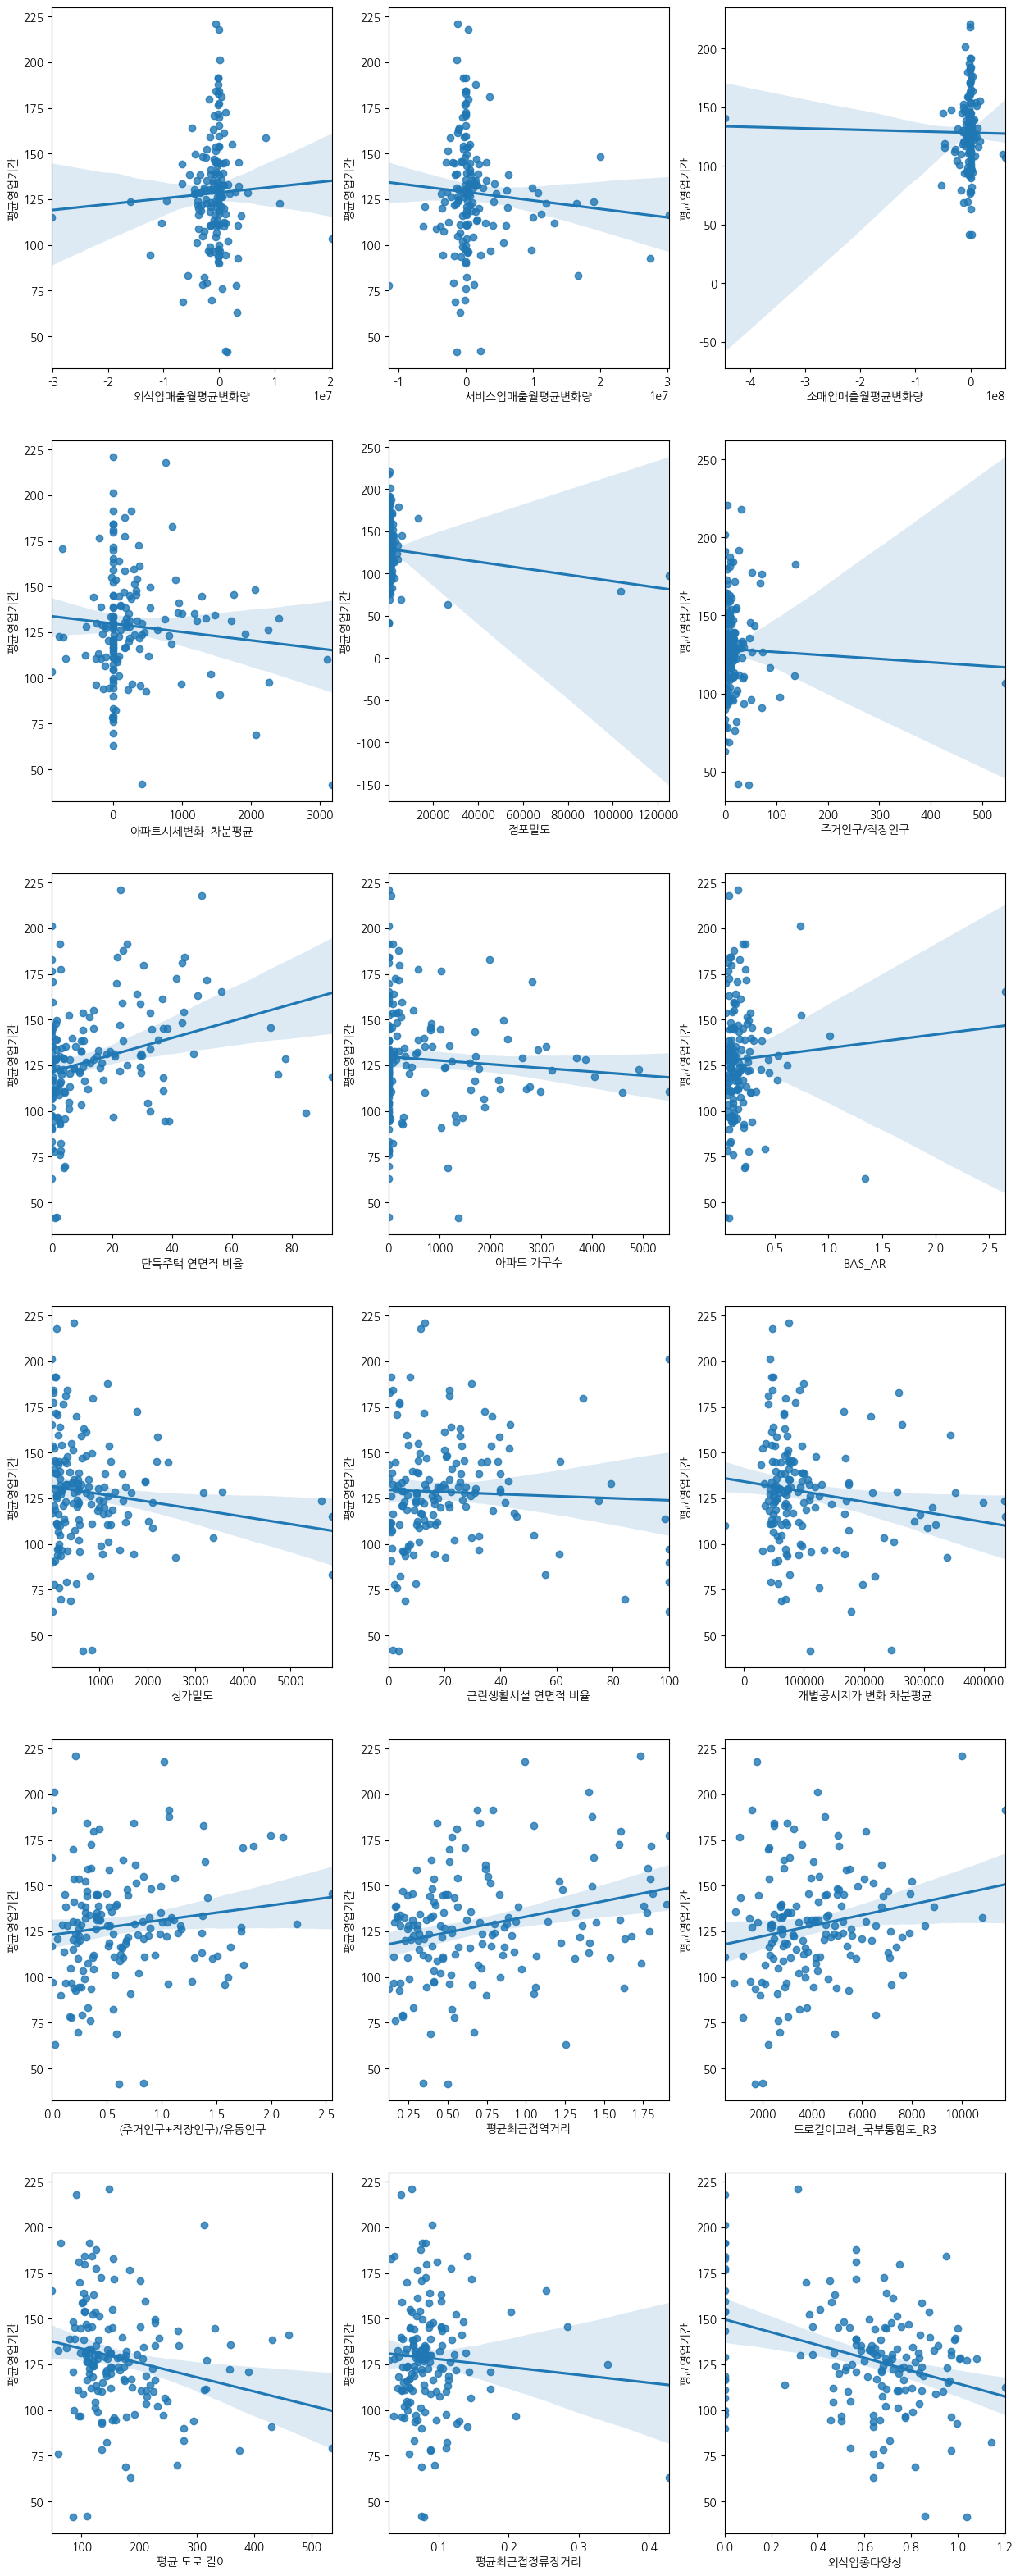

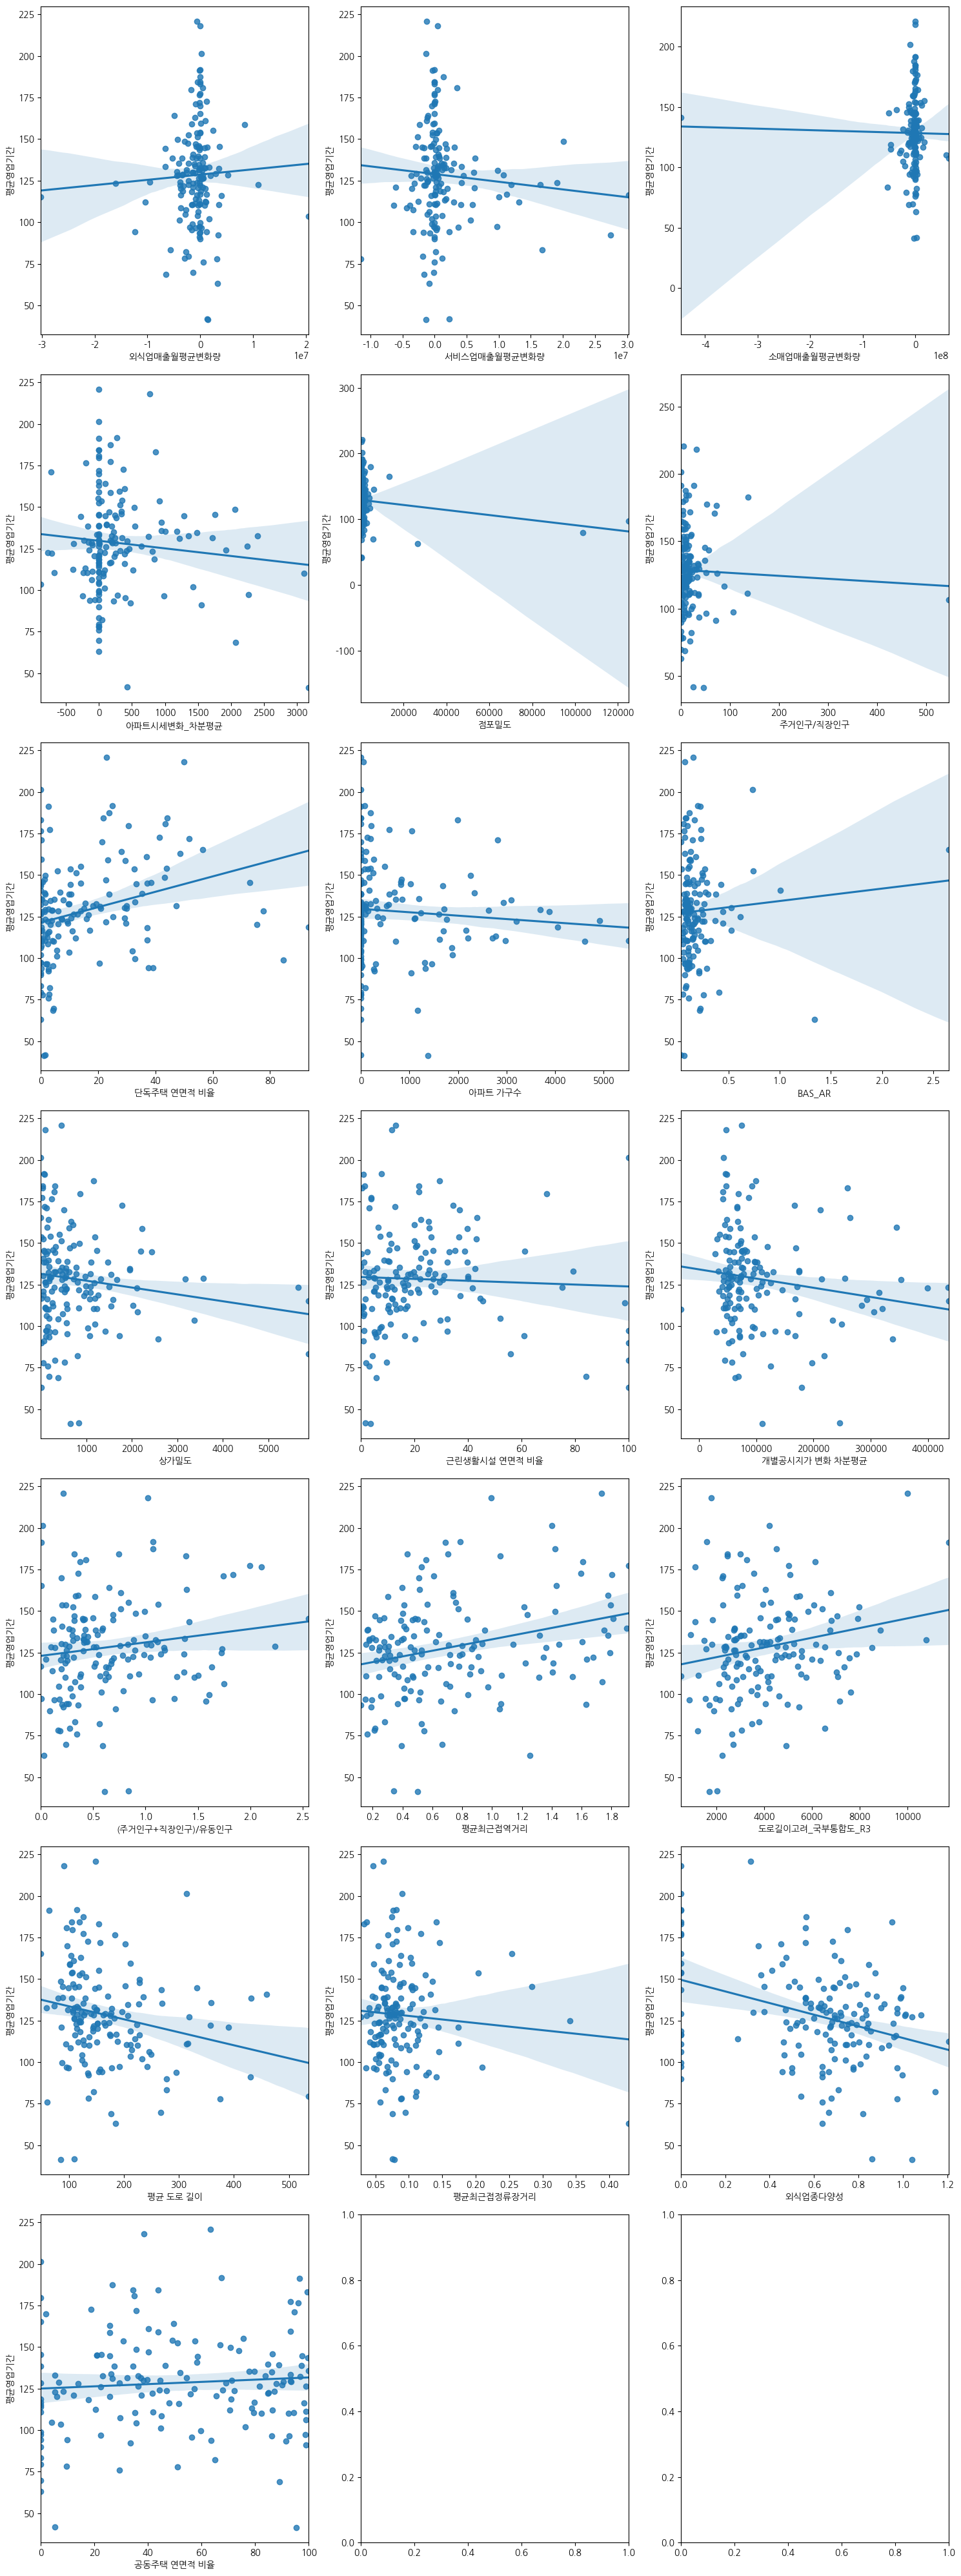

In [894]:
fig, axes = plt.subplots(nrows=int(len(optimal_feature)/3)+1,ncols=3,figsize=(15,40))

for idx, col in enumerate(optimal_feature):
    sns.regplot(x=col,y='평균영업기간',data=clean_data,ax=axes[int(idx/3),idx % 3])

plt.tight_layout()
plt.show()

## 5.2 MODELING

In [86]:
#Calibrate GWR model
# 평균영업기간

gwr_selector = Sel_BW(s_coords, s_y2, s_X,kernel='bisquare',spherical=True)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_model = GWR(s_coords, s_y2, s_X, gwr_bw,kernel='bisquare',spherical=True)
gwr_results = gwr_model.fit()

151.0


In [289]:
gwr_coef_df = pd.DataFrame(gwr_results.params)
gwr_coef_df.columns = ['intercept']+list(clean_data.iloc[:,ind_var_col].columns)
gwr_coef_df['x'] = u
gwr_coef_df['y'] = v
gwr_coef_df['BAS_ID'] = clean_data['BAS_ID']
gwr_coef_df.to_csv('../data/전처리 파일/GWR 회귀계수(평균영업기간,자동차제거,매출 log,null유지,1108).csv',index=False,encoding='euc-kr')

In [87]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 152
Number of covariates:                                                    32

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         135304.749
Log-likelihood:                                                    -731.825
AIC:                                                               1527.651
AICc:                                                              1548.668
BIC:                                                             134701.883
R2:                                                                   0.457
Adj. R2:                                                              0.317

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### 5.2.1 Scaling

#### 5.2.1.1 왜도, 첨도 확인

In [32]:
from scipy.stats import skew

skew_val = []
# kurtosis_val = []

for i, col in enumerate(list(dX)):
#     print('{0}. {1} : {2:.3f}'.format(i+1,col,skew(dX.loc[:,col])))
    skew_val.append(skew(dX.loc[:,col]))
#     kurtosis_val.append(kurtosis(dX.loc[:,col],fisher=True))

skew_data = pd.DataFrame({'column name': list(dX),'skew':skew_val})
# kurtosis_data = pd.DataFrame({'column name':list(dX),'kurtosis':kurtosis_val})

In [33]:
skew_col = skew_data[skew_data['skew'].apply(lambda x : abs(x)) > 2]['column name']
# kurtosis_col = kurtosis_data[kurtosis_data['kurtosis'].apply(lambda x : abs(x)) > 3]['column name']

# skew_col
skew_col = skew_col.values

# kurtosis_col
# kurtosis_col = kurtosis_col.values
# 이 데이터들의 분포를 살펴보자.

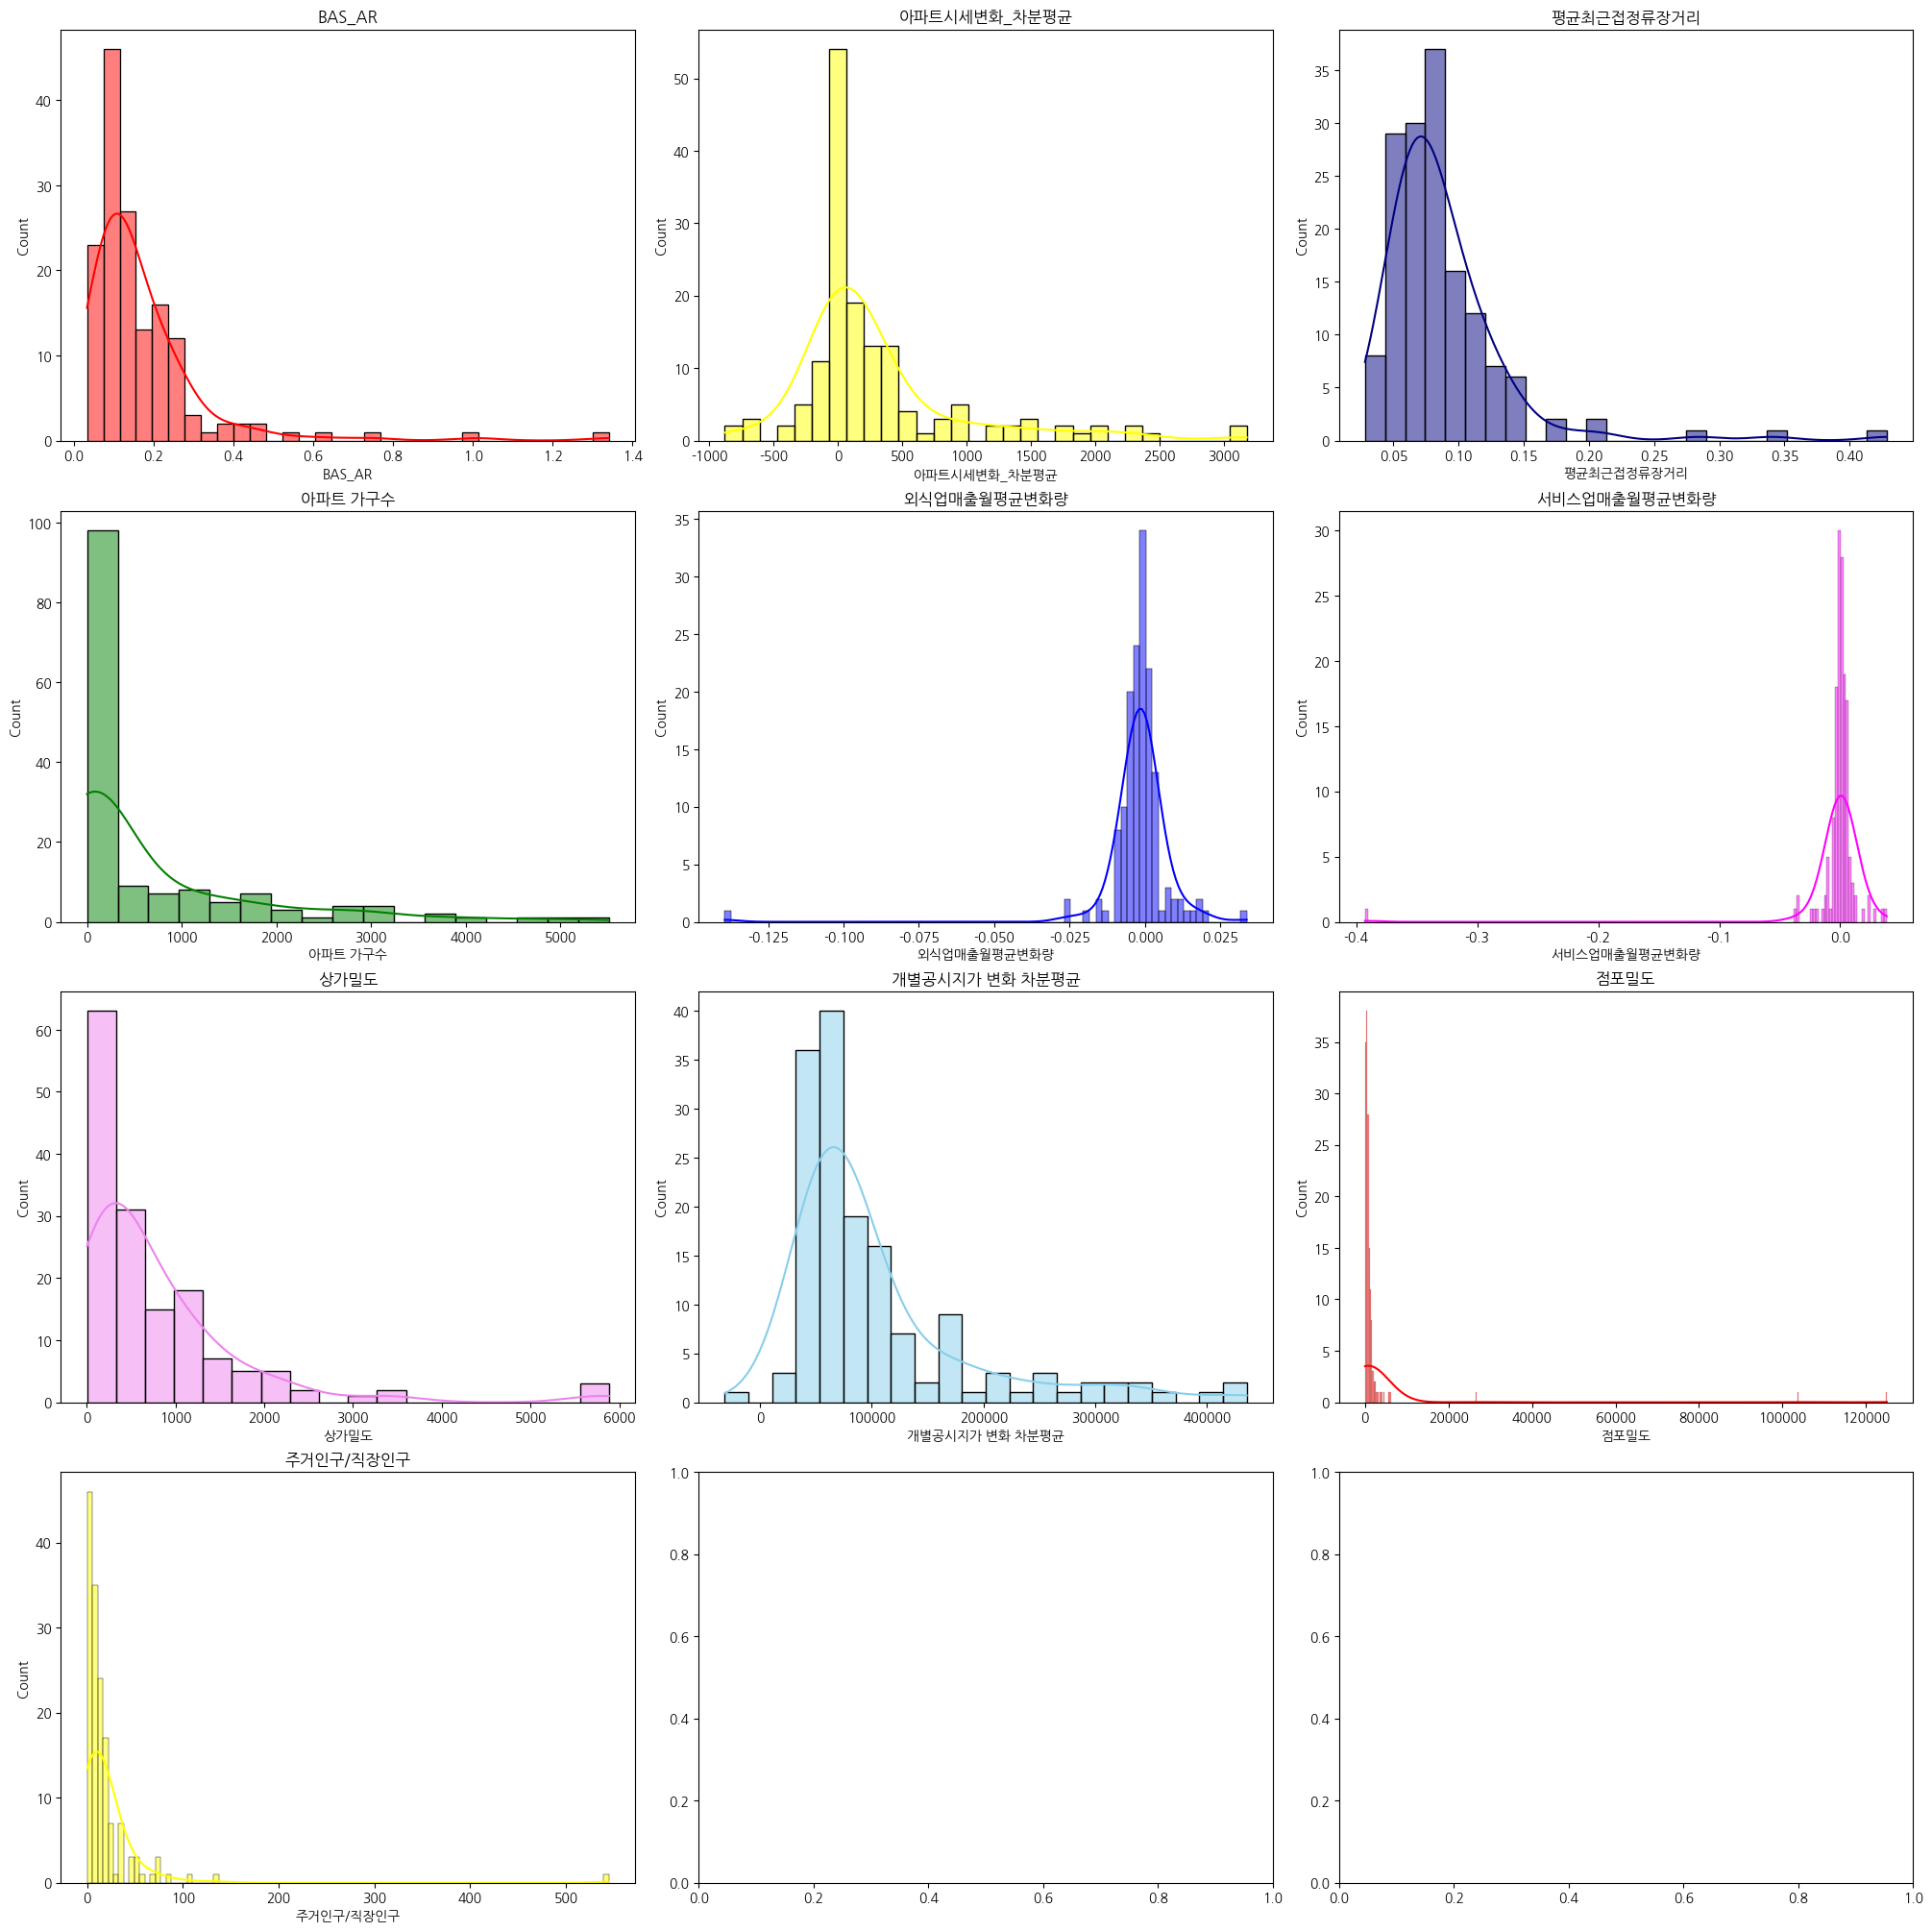

In [34]:
fig, axes = plt.subplots((int(len(skew_col)/3)+1),3,figsize=(20,20),constrained_layout=True)
color = ['red','yellow','navy','green','blue','magenta','violet','skyblue']

for i in range(int(len(skew_col)/3)+1):
    for j in range(3):
        if (3*i+j) == len(skew_col):
            break
        
        sns.histplot(ax=axes[i,j], data=dX, x=skew_col[(3*i+j)], kde=True,color=color[(3*i+j) % 8])
        axes[i,j].set_title(skew_col[3*i+j])
         
plt.show()

In [35]:
# 해당 컬럼들은 log변환 진행.

# skew = 2, kurtosis=3
log_ok_col = skew_col[[0,2,3,6,8,9]]
# robust_ok_col = diff

# skew = 3 일때
# log_ok_col = skew_col[[0,1,3,4,5,6,9,11,12]]

scaled_dX = dX.copy()
scaled_dX.loc[:,log_ok_col] = scaled_dX.loc[:,log_ok_col].apply(lambda x : np.log1p(x))
# scaled_dX.loc[:,robust_ok_col] = RobustScaler().fit_transform(scaled_dX.loc[:,robust_ok_col])

In [36]:
scaled_skew = []

for i, col in enumerate(list(log_ok_col)):
#     print('{0}. {1} : {2:.3f}'.format(i+1,col,skew(dX.loc[:,col])))
    scaled_skew.append(skew(scaled_dX.loc[:,col]))
#     kurtosis_val.append(kurtosis(dX.loc[:,col],fisher=True))

scaled_skew_data = pd.DataFrame({'column name': log_ok_col,'skew':scaled_skew})

display(skew_data[skew_data['column name'].isin(log_ok_col)])
display(scaled_skew_data)

,column name,skew
0,BAS_AR,4.127395
9,평균최근접정류장거리,3.632638
14,아파트 가구수,2.100923
24,상가밀도,2.964990
28,점포밀도,8.317659
30,주거인구/직장인구,9.139291


,column name,skew
0,BAS_AR,3.042848
1,평균최근접정류장거리,3.188317
2,아파트 가구수,-0.006490
3,상가밀도,-0.449712
4,점포밀도,0.564270
5,주거인구/직장인구,-0.068425


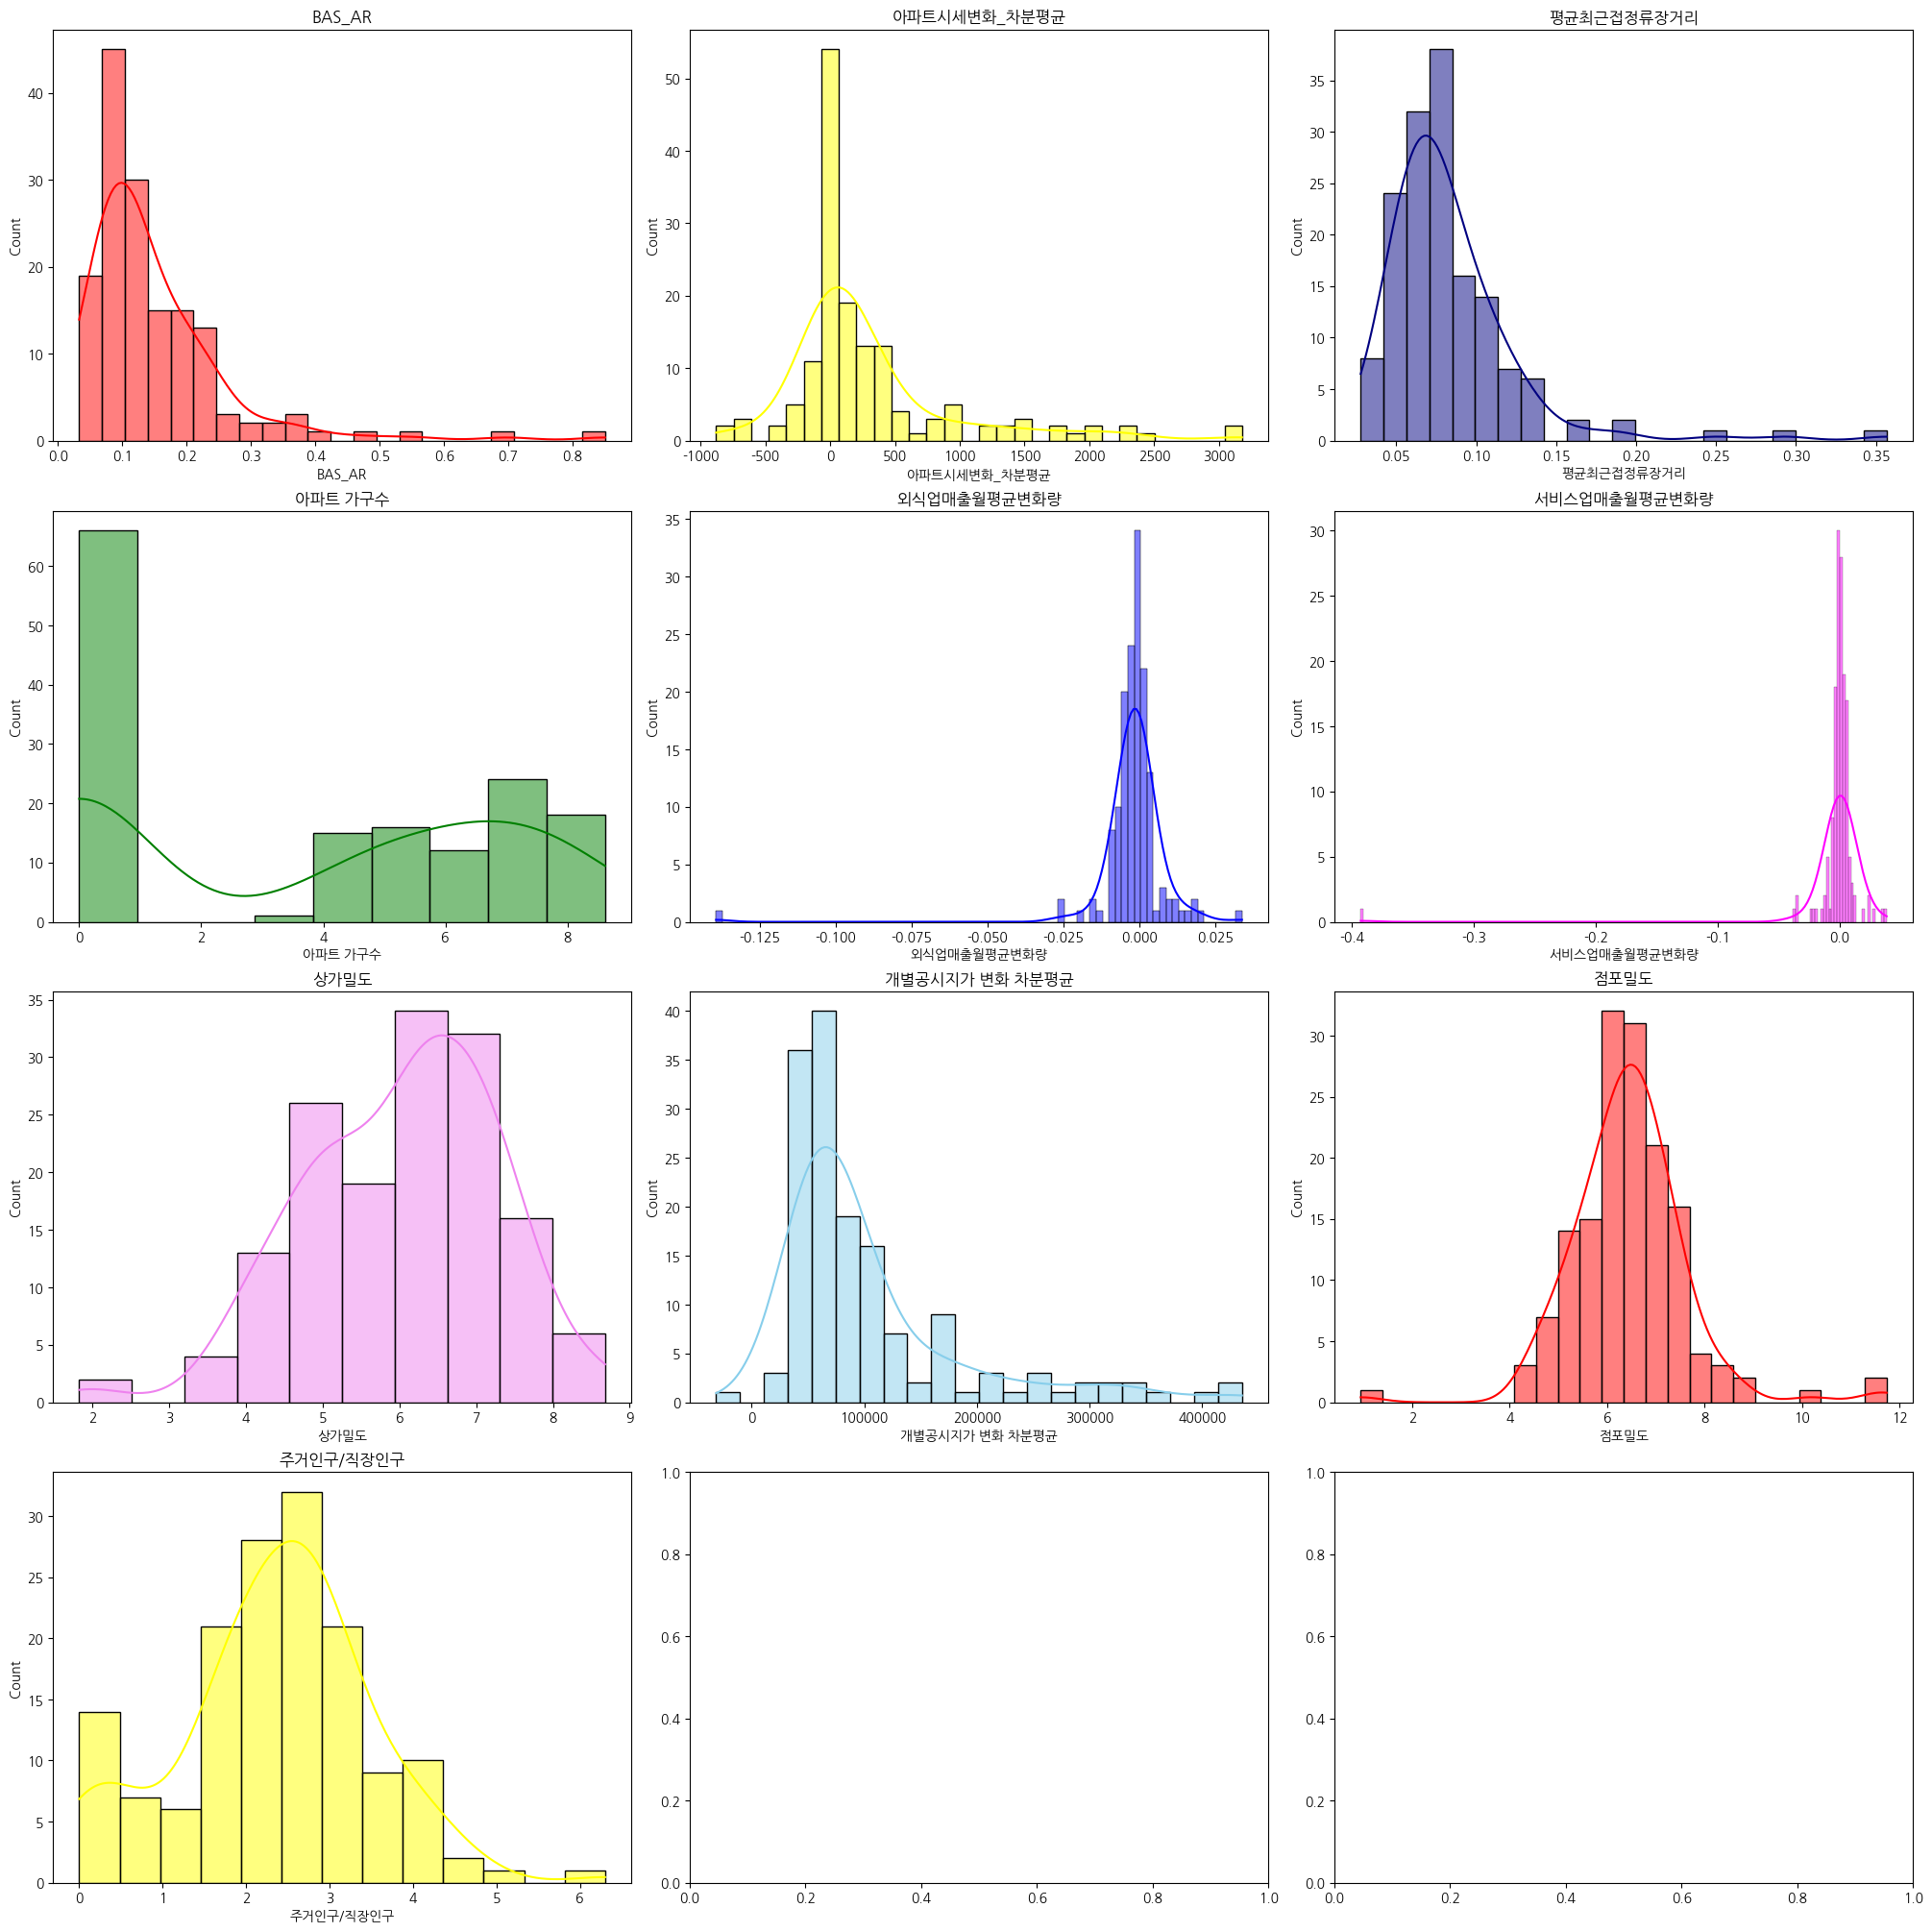

In [37]:
fig, axes = plt.subplots((int(len(skew_col)/3)+1),3,figsize=(20,20),constrained_layout=True)
color = ['red','yellow','navy','green','blue','magenta','violet','skyblue']

for i in range(int(len(skew_col)/3)+1):
    for j in range(3):
        if (3*i+j) == len(skew_col):
            break
        
        sns.histplot(ax=axes[i,j], data=scaled_dX, x=skew_col[(3*i+j)], kde=True,color=color[(3*i+j) % 8])
        axes[i,j].set_title(skew_col[3*i+j])
        
plt.show()

#### 5.2.1.2 Remodeling

In [41]:
# 스케일링된 독립변수 설정.
s_X = scaled_dX.values

# 모델 생성
gwr_selector = Sel_BW(s_coords, s_y2, s_X,kernel='bisquare',spherical=True)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_model = GWR(s_coords, s_y2, s_X, gwr_bw,kernel='bisquare',spherical=True)
gwr_results = gwr_model.fit()

151.0


In [42]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 152
Number of covariates:                                                    32

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         135304.749
Log-likelihood:                                                    -731.825
AIC:                                                               1527.651
AICc:                                                              1548.668
BIC:                                                             134701.883
R2:                                                                   0.457
Adj. R2:                                                              0.317

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

#### 5.2.1.3 MinMaxScaling
- 교차검증 시 안했을 때의 best score와 같았음.

In [43]:
scaler = MinMaxScaler()
mm_scaled_dX = scaled_dX.copy()
mm_scaled_dX = pd.DataFrame(scaler.fit_transform(mm_scaled_dX),columns=mm_scaled_dX.columns)
s_X = mm_scaled_dX.values

#### 5.2.1.4 Remodeling

In [50]:
# 모델 생성
gwr_selector = Sel_BW(s_coords, s_y2, s_X,kernel='bisquare',spherical=True)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_model = GWR(s_coords, s_y2, s_X, gwr_bw,kernel='bisquare',spherical=True)
gwr_results = gwr_model.fit()

151.0


In [51]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 152
Number of covariates:                                                    32

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         135304.749
Log-likelihood:                                                    -731.825
AIC:                                                               1527.651
AICc:                                                              1548.668
BIC:                                                             134701.883
R2:                                                                   0.457
Adj. R2:                                                              0.317

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

#### 5.2.1.5 Standard Scaling

In [56]:
scaler = StandardScaler()
ss_scaled_dX = scaled_dX.copy()
ss_scaled_dX = pd.DataFrame(scaler.fit_transform(ss_scaled_dX),columns=ss_scaled_dX.columns)
s_X = ss_scaled_dX.values

In [57]:
# 스케일링 후 다중공선성 제거

vif_result = RFE(ss_scaled_dX)
scaled_optimal_feature = vif_result['features'].values.tolist()
scaled_optimal_feature

['아파트시세변화_차분평균',
 '서비스업매출비율',
 '소매업매출월평균변화량',
 '외식업매출월평균변화량',
 '외식업매출비율',
 '서비스업매출월평균변화량',
 '건물노후도',
 '평균최근접역거리',
 '기초구역평균_전체통합도',
 '외식업종다양성',
 '주중 / 주말 비율',
 '기초구역평균_국부통합도_R3',
 '개별공시지가 변화 차분평균',
 '평균최근접정류장거리',
 '(주거인구+직장인구)/유동인구',
 '평균 도로 길이',
 '도로길이고려_국부통합도_R3',
 '소매업종다양성',
 '단독주택 연면적 비율',
 '도로율',
 '서비스업종다양성',
 '아파트 가구수',
 '06 to 18 / 18 to 06',
 '점포밀도',
 'BAS_AR',
 '근린생활시설 연면적 비율',
 '주거인구/직장인구',
 '공동주택 연면적 비율']

#### 5.2.1.6 Remodeling

In [58]:
# 모델 생성
gwr_selector = Sel_BW(s_coords, s_y2, s_X,kernel='bisquare',spherical=True)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_model = GWR(s_coords, s_y2, s_X, gwr_bw,kernel='bisquare',spherical=True)
gwr_results = gwr_model.fit()

151.0


In [59]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 152
Number of covariates:                                                    32

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         135304.749
Log-likelihood:                                                    -731.825
AIC:                                                               1527.651
AICc:                                                              1548.668
BIC:                                                             134701.883
R2:                                                                   0.457
Adj. R2:                                                              0.317

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### 5.2.2 교차검증

In [60]:
def cross_validation_gwr(lX, ly, kernel,ran_state):
    train_aic = np.zeros(5)
    train_ll = np.zeros(5)
    train_r2 = np.zeros(5)
    train_adj_r2 = np.zeros(5)
    residual = []

    cv = KFold(5, shuffle=True, random_state=ran_state)

    for i, (idx_train, idx_test) in enumerate(cv.split(X = lX, y = ly)):
    
#         print('====================== FOLD {} ======================'.format(i))
        # train, test split
        local_res = np.zeros(158)
        local_X_train, local_y_train = lX[idx_train], ly[idx_train]
        local_u_train = clean_data.iloc[idx_train]['x']
        local_v_train = clean_data.iloc[idx_train]['y']
        local_train_coords = list(zip(local_u_train,local_v_train))
    
        local_X_test, local_y_test = lX[idx_test], ly[idx_test]
        local_u_test = clean_data.iloc[idx_test]['x']
        local_v_test = clean_data.iloc[idx_test]['y']
        local_test_coords = list(zip(local_u_test,local_v_test))
    
        # 모델 생성
        gwr_selector = Sel_BW(local_train_coords, local_y_train, local_X_train,kernel=kernel,spherical=True)
        gwr_bw = gwr_selector.search(bw_min=2)
#         print('BAND WIDTH : {}'.format(gwr_bw))
        gwr_model = GWR(local_train_coords, local_y_train, local_X_train, gwr_bw,kernel=kernel,spherical=True)
        gwr_results = gwr_model.fit()
        
        # Prediction
        scale = gwr_results.scale
        residuals = gwr_results.resid_response
        pred_results = gwr_model.predict(np.array(local_test_coords), local_X_test, scale, residuals)
        pred = pred_results.predictions.flatten()
        
        # AIC
        train_aic[i] = gwr_results.aic
    
        # R2 스코어
        train_r2[i] = gwr_results.R2
        
        # Adj. R2 스코어
        train_adj_r2[i] = gwr_results.adj_R2
#         test_r2[i] = r2_score(local_y_test,pred)
        
        # Log-Likelihood
        train_ll[i] = gwr_results.llf
#         residual.append(local_y_test.flatten()-pred)
#         train_rmse[i] = np.sqrt(gwr_results.)
#         test_rmse[i] = np.sqrt(mean_squared_error(local_y_test,pred))
    
#         print('TRAIN R2 : {:.8f}, TEST R2 : {:.8f}'.format(train_r2[i], test_r2[i]))
# #         print('TRAIN RMSE : {:.8f}, TEST RMSE : {:.8f}'.format(train_rmse[i], test_rmse[i]))
#         print("TRAIN AIC : {:.8f}".format(train_aic[i]))
#         print("TRAIN LOG-LIKELIHOOD : {:.8f}".format(train_ll[i]))
    
#     print('\n===================== 평균 결과 ======================')
#     print('TRAIN R2 : {:.8f}, TEST R2 : {:.8f}'.format(train_r2.mean(), test_r2.mean()))
# #     print('TRAIN RMSE : {:.8f}, TEST RMSE : {:.8f}'.format(train_rmse.mean(), test_rmse.mean()))
#     print("TRAIN AIC : {:.8f}".format(train_aic.mean()))
#     print("TRAIN LOG-LIKELIHOOD : {:.8f}".format(train_ll.mean()))
    
    return train_aic.mean(), train_ll.mean(), train_r2.mean(), train_adj_r2.mean()
# , residual

# cross_validation_gwr(s_X, s_y1)

### 5.2.3 Feature Selection

In [61]:
def search_best_model(kernel,ind_val,ran_state,i):
    flag = True
    min_aic = float('inf')
    max_ll = float('-inf')
    max_r2 = float('-inf')
    adj_r2 = ''
    col_list = list(ind_val.columns)
    drop_col = []

    # flag가 False라면 탈출
    while flag :  
        # 조건 초기화, 평가 치표가 업데이트 된 흔적이 있으면 다시 진입할 것이다.
        flag = False 
    
        # 사용 컬럼 업데이트
#         print('COL LIST COUNT : {}'.format(len(col_list)-len(drop_col)))
#         print('DROP COLUMN LIST COUNT : {}'.format(len(drop_col)))
        col_list = list(set(col_list) - set(drop_col))
        drop_col.clear()
    
        # 사용할 독립변수 업데이트
        temp_dX = ind_val.loc[:,col_list]
    
        # 컬럼 하나씩 지우면서 평가지표 확인
#         for col in tqdm(col_list):
        for col in col_list:
            local_X = temp_dX.drop(col,axis=1).values
            new_aic, new_ll, new_r2, new_adj_r2 = cross_validation_gwr(local_X, s_y2,kernel,ran_state)

            # 새로운 aic는 기존의 aic보다 작고, 새로운 ll은 기존의 ll보다 큰가?(AND 조건이어야 함.)
            if (new_aic < min_aic) & (new_ll > max_ll) & (max_r2 < new_r2):
                min_aic = new_aic
                max_ll = new_ll
                max_r2 = new_r2
                adj_r2 = new_adj_r2
                drop_col.append(col)
                flag = True
#                 print('========================= NEW VALIDATION =========================')
#                 print('NEW MAX R2 : {:.8f}'.format(max_r2))
#                 print('NEW MIN AIC : {:.8f}'.format(min_aic))
#                 print('NEW MAX LOG-LIKELIHOOD : {:.8f}'.format(max_ll))
    
    print('========================= RESULT =========================')
    print('KERNEL : {}'.format(kernel))
    print('RANDOM STATE : {}'.format(ran_state))
    print('DATASET NUMBER : {}'.format(i))
    print('MAX R2 : {:.8f}'.format(max_r2))
    print('Adj. R2 : {:.8f}'.format(adj_r2))
    print('MIN AIC : {:.8f}'.format(min_aic))
    print('MAX LOG-LIKELIHOOD : {:.8f}'.format(max_ll))
    print('COLUMN COUNT : {}'.format(len(col_list)))
#     print('COLUMN : {}'.format(col_list))

    
    result = pd.DataFrame({'KERNEL':kernel,'RANDOM STATE':ran_state,'DATASET NUMBER':i,'R2':max_r2
                           ,'Adj. R2':adj_r2,'AIC':min_aic,'LOG LIKELIHOOD':max_ll
                           ,'COLUMN COUNT':len(col_list),'COLUMN':[col_list]})
    
    return result

## 5.3 Dataset별 GWR Modeling

In [83]:
# 1. Raw Data
rd_X = clean_data.iloc[:,ind_var_col]

# 2. Raw Data에서 다중공선성 제거
remove_high_vif_X = clean_data.loc[:,optimal_feature]

# 3. skew가 2 이상인 데이터에 대해서 log1p를 적용한 데이터셋+standard scaler
scaled_X = ss_scaled_dX

# 4. skew가 2 이상인 데이터에 대해서 log1p를 적용하고 다중공선성을 제거한 데이터셋
remove_high_vif_scaled_X = ss_scaled_dX.loc[:,scaled_optimal_feature]

# 5. Raw Data에서 매출월평균변화량만 제거
rm_avg_X = clean_data.iloc[:,ind_var_col].drop(['서비스업매출월평균변화량','소매업매출월평균변화량','외식업매출월평균변화량'],axis=1)

# 6.skew가 2 이상인 데이터에 대해서 log1p를 적용하고 +standard~ 매출월평균변화량만 제거
scaled_rm_avg_X = ss_scaled_dX.drop(['서비스업매출월평균변화량','소매업매출월평균변화량','외식업매출월평균변화량'],axis=1)

ind_dataset = [rd_X,remove_high_vif_X,scaled_X,remove_high_vif_scaled_X,rm_avg_X,scaled_rm_avg_X]
kernel = ['gaussian','exponential','bisquare']

aic = []
ll = []
r2 = []
adj_r2 = []
ker = []
dataset_idx = []

for func in kernel:
    for i,s_X in enumerate(ind_dataset):
        s_X = s_X.values
        # 모델 생성
        gwr_selector = Sel_BW(s_coords, s_y2, s_X,kernel=func,spherical=True)
        gwr_bw = gwr_selector.search(bw_min=2)
        gwr_model = GWR(s_coords, s_y2, s_X, gwr_bw,kernel=func,spherical=True)
        gwr_results = gwr_model.fit()
    
        # 평가 지표
        aic.append(gwr_results.aic)
        ll.append(gwr_results.llf)
        r2.append(gwr_results.R2)
        adj_r2.append(gwr_results.adj_R2)
        ker.append(func)
        dataset_idx.append(i)

valid_result = pd.DataFrame({'Data Number':dataset_idx,'Kernel':ker,'R2':r2,'Adj. R2':adj_r2
                             ,'AIC':aic,'Log-Likelihood':ll})

In [84]:
valid_result.sort_values(by='Adj. R2',ascending=False)

,Data Number,Kernel,R2,Adj. R2,AIC,Log-Likelihood
17,5,bisquare,0.604074,0.431792,1509.319411,-707.876188
14,2,bisquare,0.618901,0.430541,1511.843404,-704.975452
15,3,bisquare,0.592550,0.415148,1513.718332,-710.056712
11,5,exponential,0.560266,0.402028,1513.620170,-715.851897
8,2,exponential,0.571590,0.397501,1516.999540,-713.869028
16,4,bisquare,0.573104,0.393416,1518.661335,-713.599952
12,0,bisquare,0.589513,0.392326,1521.239365,-710.621153
9,3,exponential,0.546245,0.383026,1518.367904,-718.237257
10,4,exponential,0.534638,0.370701,1520.986867,-720.156937
6,0,exponential,0.547323,0.366603,1524.279071,-718.056523


### 5.3.1 Feature Selection

In [67]:
import time

list_df = ind_dataset
kernel = ['gaussian','bisquare','exponential']
random_state = [10]

conclusion = pd.DataFrame()
count = 0
start_time = time.time()

for k in kernel:
    for i, df in enumerate(list_df):
        for rs in random_state:
            result = search_best_model(k,df,rs,i)
            conclusion= pd.concat([conclusion,result],axis=0,ignore_index=True)
            count += 1
            print('진행률 : {0:.2f}%, 소요시간 : {1:.2f}분'.format(count/(len(kernel)*len(list_df)*len(random_state))*100,(time.time()-start_time)/60))

conclusion.head()

========================= RESULT =========================
KERNEL : gaussian
RANDOM STATE : 10
DATASET NUMBER : 0
MAX R2 : 0.53103625
Adj. R2 : 0.34729271
MIN AIC : 1222.77759882
MAX LOG-LIKELIHOOD : -576.43082115
COLUMN COUNT : 24
진행률 : 5.56%, 소요시간 : 0.84분
========================= RESULT =========================
KERNEL : gaussian
RANDOM STATE : 10
DATASET NUMBER : 1
MAX R2 : 0.51563270
Adj. R2 : 0.39854867
MIN AIC : 1205.56614660
MAX LOG-LIKELIHOOD : -577.97020793
COLUMN COUNT : 7
진행률 : 11.11%, 소요시간 : 1.92분
========================= RESULT =========================
KERNEL : gaussian
RANDOM STATE : 10
DATASET NUMBER : 2
MAX R2 : 0.54353781
Adj. R2 : 0.36333512
MIN AIC : 1219.82305888
MAX LOG-LIKELIHOOD : -574.78601549
COLUMN COUNT : 27
진행률 : 16.67%, 소요시간 : 2.87분
========================= RESULT =========================
KERNEL : gaussian
RANDOM STATE : 10
DATASET NUMBER : 3
MAX R2 : 0.52340715
Adj. R2 : 0.35546110
MIN AIC : 1219.71901222
MAX LOG-LIKELIHOOD : -577.43842608
COLUMN COUN

,KERNEL,RANDOM STATE,DATASET NUMBER,R2,Adj. R2,AIC,LOG LIKELIHOOD,COLUMN COUNT,COLUMN
0,gaussian,10,0,0.531036,0.347293,1222.777599,-576.430821,24,"[서비스업매출비율, 소매업매출비율, 외식업매출월평균변화량, 아파트 가구수, 도로율,..."
1,gaussian,10,1,0.515633,0.398549,1205.566147,-577.970208,7,"[점포밀도, BAS_AR, 평균 도로 길이, 외식업매출월평균변화량, 아파트 가구수,..."
2,gaussian,10,2,0.543538,0.363335,1219.823059,-574.786015,27,"[아파트시세변화_차분평균, 기초구역평균_국부통합도_R3, 소매업매출비율, 근린생활시..."
3,gaussian,10,3,0.523407,0.355461,1219.719012,-577.438426,23,"[아파트시세변화_차분평균, 서비스업매출비율, 도로길이고려_국부통합도_R3, 외식업매..."
4,gaussian,10,4,0.516763,0.351181,1220.028465,-578.224516,23,"[아파트시세변화_차분평균, 근린생활시설 연면적 비율, 기초구역평균_전체통합도, 개별..."


In [68]:
condition = ((conclusion['AIC'].min() == conclusion['AIC']) | (conclusion['LOG LIKELIHOOD'].max() == conclusion['LOG LIKELIHOOD']) 
             | (conclusion['R2'] == conclusion['R2'].max()))
conclusion[condition]

,KERNEL,RANDOM STATE,DATASET NUMBER,R2,Adj. R2,AIC,LOG LIKELIHOOD,COLUMN COUNT,COLUMN
8,bisquare,10,2,0.681447,0.467081,1204.630088,-552.809799,26,"[아파트시세변화_차분평균, 소매업매출비율, 근린생활시설 연면적 비율, 외식업매출월평..."
11,bisquare,10,5,0.660567,0.462081,1204.468987,-556.732188,24,"[아파트시세변화_차분평균, 소매업매출비율, 근린생활시설 연면적 비율, 기초구역평균_..."


In [70]:
conclusion.sort_values(by='Adj. R2',ascending=False).head()

,KERNEL,RANDOM STATE,DATASET NUMBER,R2,Adj. R2,AIC,LOG LIKELIHOOD,COLUMN COUNT,COLUMN
8,bisquare,10,2,0.681447,0.467081,1204.630088,-552.809799,26,"[아파트시세변화_차분평균, 소매업매출비율, 근린생활시설 연면적 비율, 외식업매출월평..."
11,bisquare,10,5,0.660567,0.462081,1204.468987,-556.732188,24,"[아파트시세변화_차분평균, 소매업매출비율, 근린생활시설 연면적 비율, 기초구역평균_..."
9,bisquare,10,3,0.656078,0.453350,1206.377403,-557.440227,24,"[아파트시세변화_차분평균, 서비스업매출비율, 근린생활시설 연면적 비율, 도로길이고려..."
6,bisquare,10,0,0.663889,0.444429,1209.492570,-556.068231,25,"[아파트시세변화_차분평균, 소매업매출비율, 근린생활시설 연면적 비율, 외식업매출월평..."
10,bisquare,10,4,0.639761,0.436517,1209.671795,-560.279236,24,"[아파트시세변화_차분평균, 소매업매출비율, 근린생활시설 연면적 비율, 기초구역평균_..."


#### 5.3.1.1 Remodeling

In [88]:
idx = 8
kernel = conclusion.iloc[idx]['KERNEL']
col = conclusion.iloc[idx]['COLUMN']

# s_X = ind_dataset[idx].loc[:,col].values
s_X = ind_dataset[conclusion.iloc[idx]['DATASET NUMBER']].loc[:,col].values

In [89]:
#Calibrate GWR model
# 평균영업기간

gwr_selector = Sel_BW(s_coords, s_y1, s_X,kernel=kernel,spherical=True)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_model = GWR(s_coords, s_y1, s_X, gwr_bw,kernel=kernel,spherical=True)
gwr_results = gwr_model.fit()

151.0


In [91]:
gwr_coef_df = pd.DataFrame(gwr_results.params)
gwr_coef_df.columns = ['intercept']+col
gwr_coef_df['x'] = u
gwr_coef_df['y'] = v
gwr_coef_df['BAS_ID'] = clean_data['BAS_ID']
gwr_coef_df.to_csv('../data/전처리 파일/GWR 회귀계수(평균폐업기간,자동차제거,매출 log,null유지,1109).csv',index=False,encoding='euc-kr')

In [90]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 152
Number of covariates:                                                    27

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          65019.698
Log-likelihood:                                                    -676.130
AIC:                                                               1406.259
AICc:                                                              1421.462
BIC:                                                              64391.713
R2:                                                                   0.479
Adj. R2:                                                              0.370

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [92]:
conclusion.to_csv('../data/최적모델평가지표(평균영업기간,자동차제거,매출log,null유지,1109).csv',encoding='euc-kr',index=False)

# 6. T-검정
- 예측값과 실제값의 평균이 서로 차이가 있는지 검정한다.

In [ ]:
# 필요 데이터셋 생성
s_X = pd.concat([dX.loc[:,col],clean_data.loc[:,['x','y']]],axis=1)

# train, test split
X_train, X_test, y_train, y_test = train_test_split(s_X, s_y1, test_size=0.2, shuffle=True,random_state=34)

# train 좌표 생성
u_train = X_train.loc[:,'x']
v_train = X_train.loc[:,'y']
train_coords = list(zip(u_train,v_train))

# test 좌표 생성
u_test = X_test.loc[:,'x']
v_test = X_test.loc[:,'y']
test_coords = list(zip(u_test,v_test))

# train, test set 독립변수 리스트에서 좌표 제거
X_train.drop(['x','y'],axis=1,inplace=True)
X_test.drop(['x','y'],axis=1,inplace=True)

X_train = X_train.values
X_test = X_test.values

# 모델 생성
gwr_selector = Sel_BW(train_coords, y_train, X_train,kernel='gaussian')
gwr_bw = gwr_selector.search(bw_min=2)

print('BAND WIDTH : {}'.format(gwr_bw))
gwr_model = GWR(train_coords, y_train, X_train, gwr_bw,kernel='gaussian')
gwr_results = gwr_model.fit()
    
# Prediction
scale = gwr_results.scale
residuals = gwr_results.resid_response
pred_results = gwr_model.predict(np.array(test_coords), X_test, scale, residuals)
pred = pred_results.predictions.flatten() 

## 7.1 정규성 검증

In [ ]:
test = stats.shapiro(y_test)
print('검정통계량 : {0}\np-value : {1}'.format(test[0],test[1]))

# 유의 수준 0.05에서 귀무가설을 기각할 수 없으므로 y_test는 정규성을 따른다.

In [ ]:
test = stats.shapiro(pred)
print('검정통계량 : {0}\np-value : {1}'.format(test[0],test[1]))

# 유의수준 0.05에서 귀무가설을 기각하고 대립가설을 채택
# 따라서 정규성을 띄지 않는다.

In [ ]:
df = pd.DataFrame({'pred':pred,'test':y_test.flatten()})
df.describe()

In [ ]:
# 독립이표본 t-test
result = stats.ttest_ind(pred, y_test, equal_var=False)
print('p-value : {:.8f}'.format(result[1][0]))

# 유의 수준 0.05에서 귀무가설을 기각할 수 없으므로 두 집단 간의 평균 차이가 없다고 말할 수 있다.

In [ ]:
ax = plt.subplot()
sns.distplot(y_test,ax=ax,color='red',label='test set',hist=False)
sns.distplot(pred,ax=ax,color='violet',label='prediction',hist=False)
ax.set_title('Prediction vs Test Set')
ax.legend()
plt.show()